[Media Effect Estimation with PyMC: Adstock, Saturation & Diminishing Returns](https://juanitorduz.github.io/pymc_mmm/)

In [93]:
import numpy as np
import pandas as pd
import xarray as xr
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn.base import BaseEstimator, TransformerMixin
# from scipy.ndimage import gaussian_filter
from sklearn.preprocessing import MaxAbsScaler
from scipy.stats import pearsonr

from typing import Union

from utils.orduz.tools import geometric_adstock, logistic_saturation

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# DATA

In [41]:
data_df = pd.read_csv('../../../data/mock/mock_data_orduz.csv', parse_dates=['date'])

In [42]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   index                 179 non-null    int64         
 1   date                  179 non-null    datetime64[ns]
 2   year                  179 non-null    int64         
 3   month                 179 non-null    int64         
 4   dayofyear             179 non-null    int64         
 5   z                     179 non-null    float64       
 6   z_adstock             179 non-null    float64       
 7   z_adstock_saturated   179 non-null    float64       
 8   beta                  179 non-null    float64       
 9   z_effect              179 non-null    float64       
 10  effect_ratio          179 non-null    float64       
 11  effect_ratio_smooth   179 non-null    float64       
 12  trend                 179 non-null    float64       
 13  cs                  

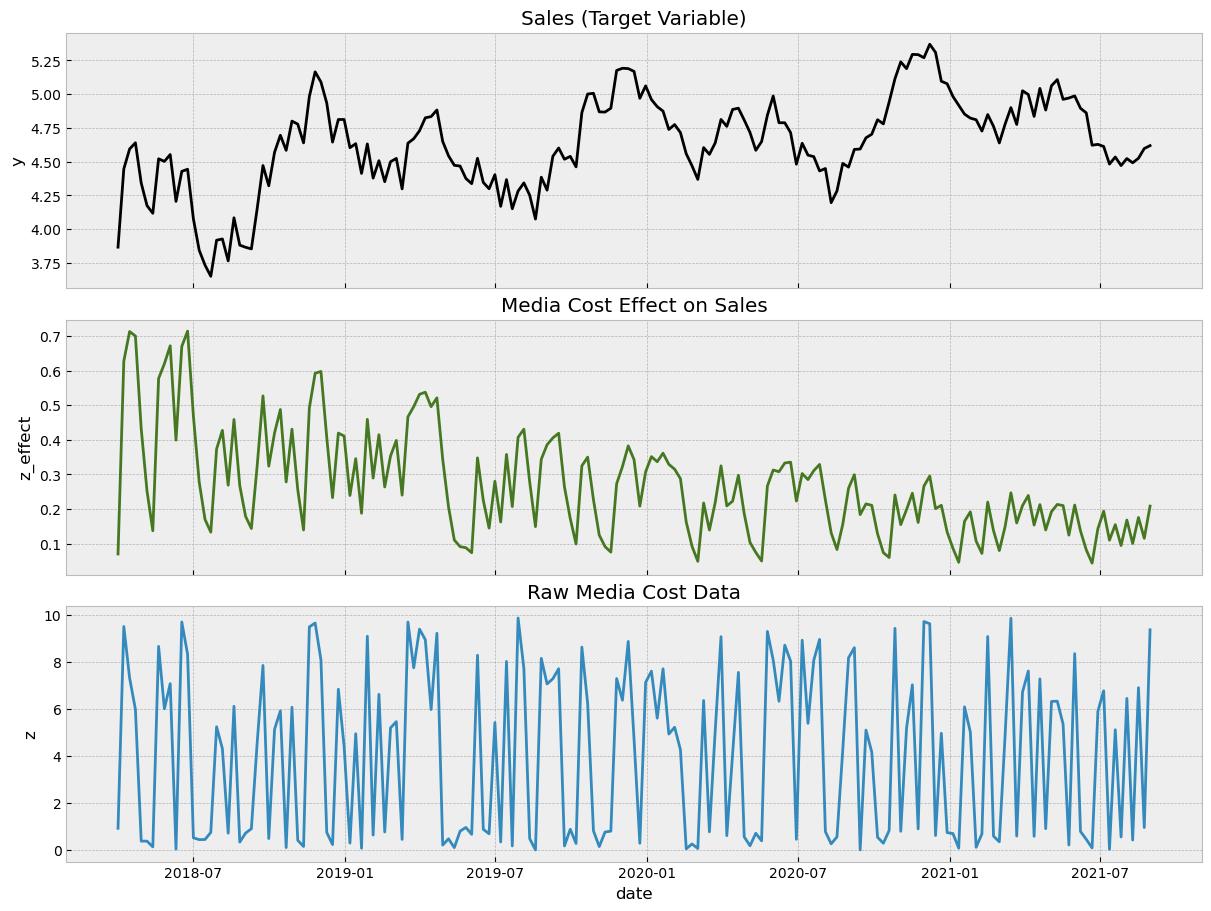

In [10]:
fig, ax = plt.subplots(
    nrows=3,
    ncols=1,
    figsize=(12, 9),
    sharex=True,
    sharey=False,
    layout="constrained"
)
sns.lineplot(x="date", y="y", color="black", data=data_df, ax=ax[0])
ax[0].set(title="Sales (Target Variable)")
sns.lineplot(x="date", y="z_effect", color="C3", data=data_df, ax=ax[1])
ax[1].set(title="Media Cost Effect on Sales")
sns.lineplot(x="date", y="z", data=data_df, ax=ax[2])
ax[2].set(title="Raw Media Cost Data");

In [43]:
columns_to_keep = ["index", "date", "year", "month", "dayofyear", "z", "y"]

df = data_df[columns_to_keep].copy()

# FEATURES

In [13]:
t = (df.index - df.index.min()) / (df.index.max() - df.index.min())

In [14]:
n_order = 7
periods = df["dayofyear"] / 365.25
fourier_features = pd.DataFrame(
    {
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods * order)
        for order in range(1, n_order + 1)
        for func in ("sin", "cos")
    }
)

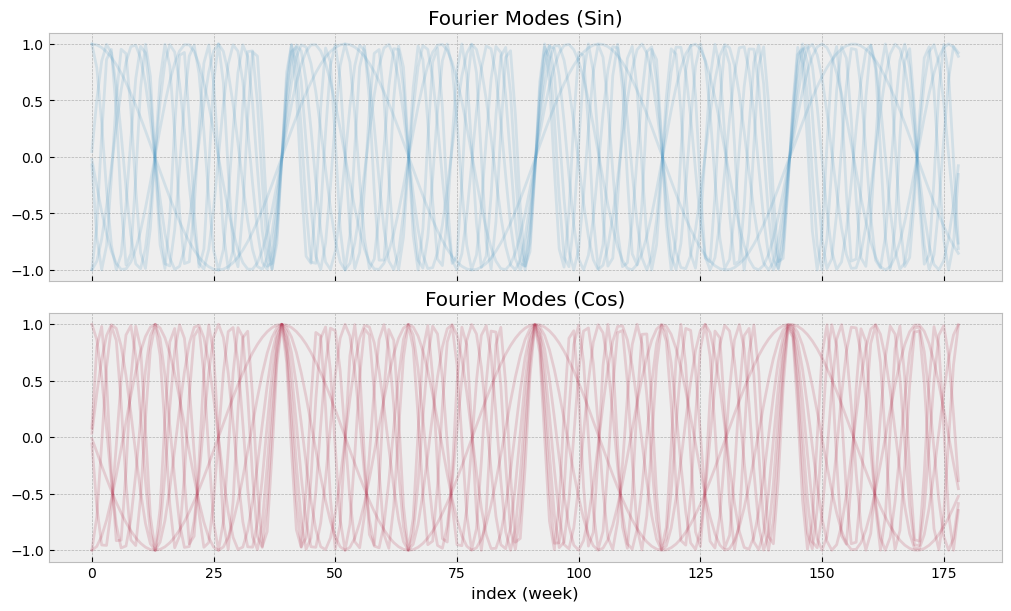

In [15]:
fig, ax = plt.subplots(nrows=2, sharex=True, layout="constrained")
fourier_features.filter(like="sin").plot(color="C0", alpha=0.15, ax=ax[0])
ax[0].get_legend().remove()
ax[0].set(title="Fourier Modes (Sin)", xlabel="index (week)")
fourier_features.filter(like="cos").plot(color="C1", alpha=0.15, ax=ax[1])
ax[1].get_legend().remove()
ax[1].set(title="Fourier Modes (Cos)", xlabel="index (week)");

In [16]:
date = df["date"].to_numpy()
date_index = df.index
y = df["y"].to_numpy()
z = df["z"].to_numpy()
t = t.values
n_obs = y.size

In [18]:
endog_scaler = MaxAbsScaler()
endog_scaler.fit(y.reshape(-1, 1))
y_scaled = endog_scaler.transform(y.reshape(-1, 1)).flatten()

channel_scaler = MaxAbsScaler()
channel_scaler.fit(z.reshape(-1, 1))
z_scaled = channel_scaler.transform(z.reshape(-1, 1)).flatten()

# MODEL 1: BASE MODEL

In [21]:
coords = {"date": date, "fourier_mode": np.arange(2 * n_order)}

with pm.Model(coords=coords) as base_model:
    # --- coords ---
    base_model.add_coord(name="dat", values=date, mutable=True)
    base_model.add_coord(name="fourier_mode", values=np.arange(2 * n_order), mutable=False)

    # --- data containers ---
    z_scaled_ = pm.MutableData(name="z_scaled", value=z_scaled, dims="date")

    # --- priors ---
    ## intercept
    a = pm.Normal(name="a", mu=0, sigma=4)
    ## trend
    b_trend = pm.Normal(name="b_trend", mu=0, sigma=2)
    ## seasonality
    b_fourier = pm.Laplace(name="b_fourier", mu=0, b=2, dims="fourier_mode")
    ## regressor
    b_z = pm.HalfNormal(name="b_z", sigma=2)
    ## standard deviation of the normal likelihood
    sigma = pm.HalfNormal(name="sigma", sigma=0.5)
    # degrees of freedom of the t distribution
    nu = pm.Gamma(name="nu", alpha=25, beta=2)

    # --- model parametrization ---
    trend = pm.Deterministic(name="trend", var=a + b_trend * t, dims="date")
    seasonality = pm.Deterministic(
        name="seasonality", var=pm.math.dot(fourier_features, b_fourier), dims="date"
    )
    z_effect = pm.Deterministic(name="z_effect", var=b_z * z_scaled_, dims="date")
    mu = pm.Deterministic(name="mu", var=trend + seasonality + z_effect, dims="date")

    # --- likelihood ---
    pm.StudentT(name="likelihood", nu=nu, mu=mu, sigma=sigma, observed=y_scaled, dims="date")

    # --- prior samples ---
    base_model_prior_predictive = pm.sample_prior_predictive()

Sampling: [a, b_fourier, b_trend, b_z, likelihood, nu, sigma]


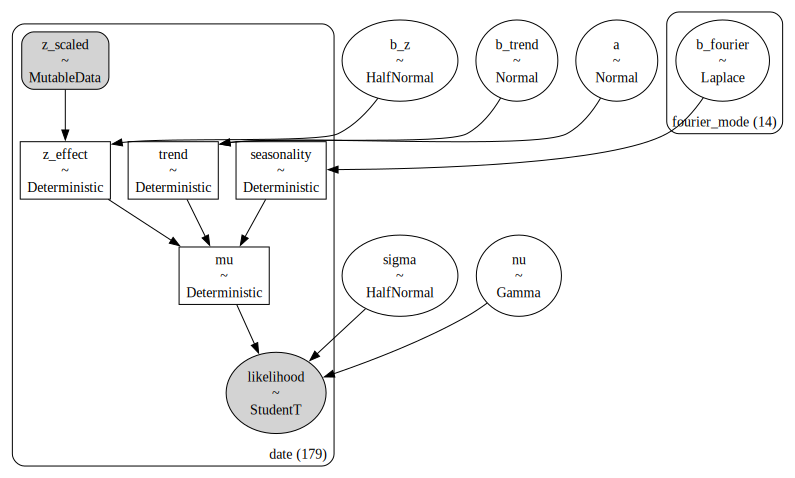

In [22]:
pm.model_to_graphviz(model=base_model)

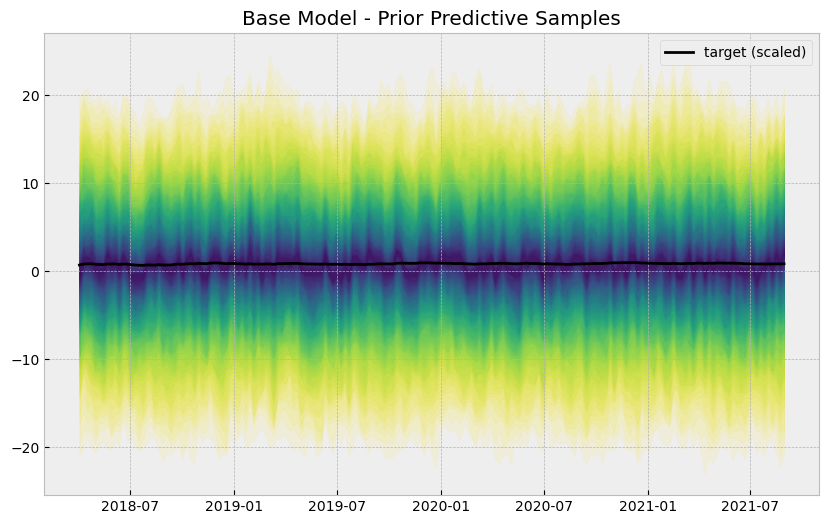

In [23]:
# useful way to color the distribution
palette = "viridis_r"
cmap = plt.get_cmap(palette)
percs = np.linspace(51, 99, 100)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))


fig, ax = plt.subplots()

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(base_model_prior_predictive.prior_predictive["likelihood"], p, axis=1)
    lower = np.percentile(
        base_model_prior_predictive.prior_predictive["likelihood"], 100 - p, axis=1
    )
    color_val = colors[i]
    ax.fill_between(
        x=date,
        y1=upper.flatten(),
        y2=lower.flatten(),
        color=cmap(color_val),
        alpha=0.1,
    )

sns.lineplot(x=date, y=y_scaled, color="black", label="target (scaled)", ax=ax)
ax.legend()
ax.set(title="Base Model - Prior Predictive Samples");

In [24]:
with base_model:
    base_model_trace = pm.sample(
        nuts_sampler="numpyro",
        draws=6_000,
        chains=4,
        idata_kwargs={"log_likelihood": True},
    )
    base_model_posterior_predictive = pm.sample_posterior_predictive(
        trace=base_model_trace
    )

Compiling...
Compilation time = 0:00:11.129331
Sampling...


  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

Sampling time = 0:00:09.445158
Transforming variables...
Transformation time = 0:00:00.753845
Computing Log Likelihood...
Log Likelihood time = 0:00:01.051989
Sampling: [likelihood]


In [27]:
az.summary(
    data=base_model_trace,
    var_names=["a", "b_trend", "b_z", "sigma", "nu"],
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
a         0.788  0.003   0.782    0.794      0.000    0.000    7959.0   
b_trend   0.119  0.005   0.110    0.127      0.000    0.000   10424.0   
b_z       0.049  0.004   0.042    0.056      0.000    0.000    7939.0   
sigma     0.016  0.001   0.014    0.018      0.000    0.000    8749.0   
nu       12.482  2.410   8.242   17.188      0.022    0.016   11246.0   

         ess_tail  r_hat  
a         12037.0    1.0  
b_trend   13513.0    1.0  
b_z       10800.0    1.0  
sigma     12897.0    1.0  
nu        12201.0    1.0

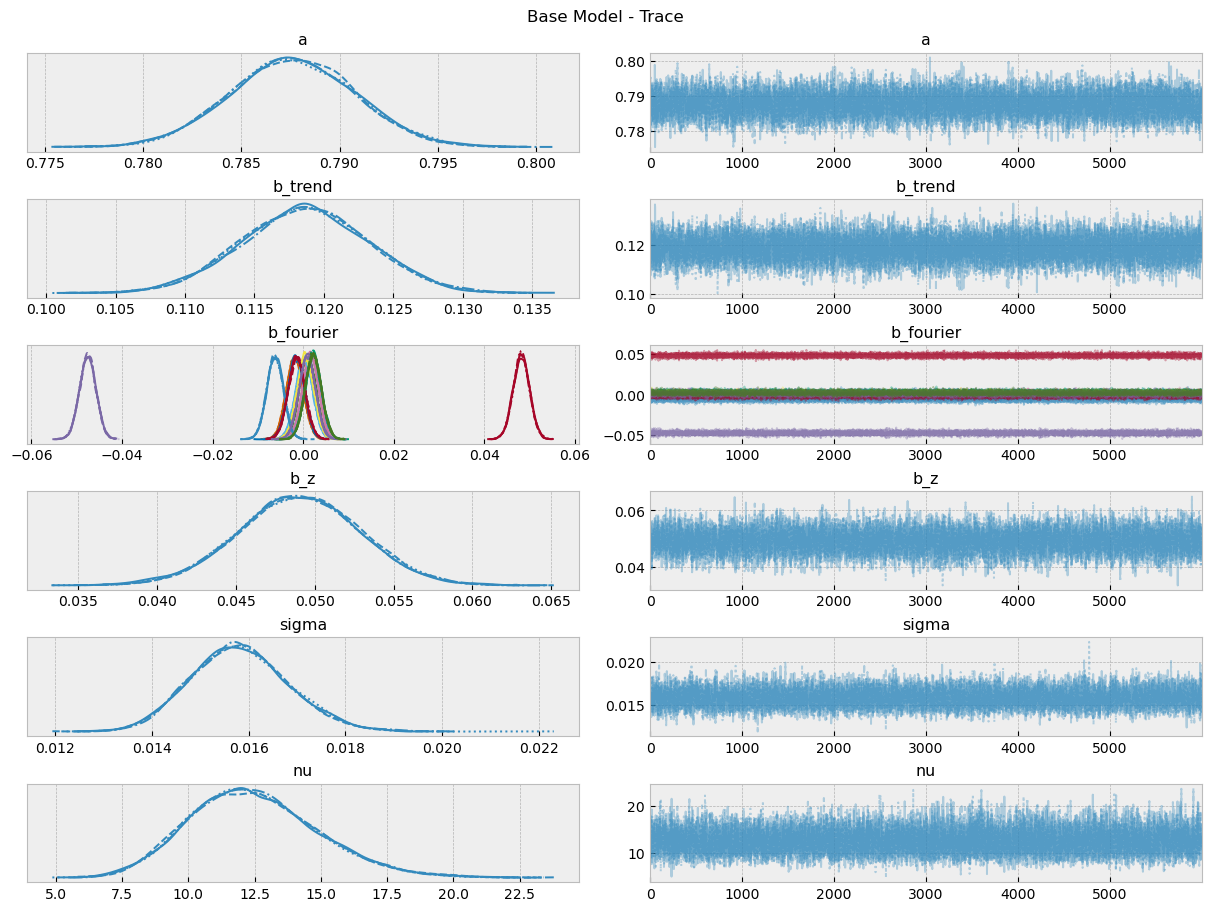

In [28]:
axes = az.plot_trace(
    data=base_model_trace,
    var_names=["a", "b_trend", "b_fourier", "b_z", "sigma", "nu"],
    compact=True,
    backend_kwargs={
        "figsize": (12, 9),
        "layout": "constrained"
    },
)
fig = axes[0][0].get_figure()
fig.suptitle("Base Model - Trace");

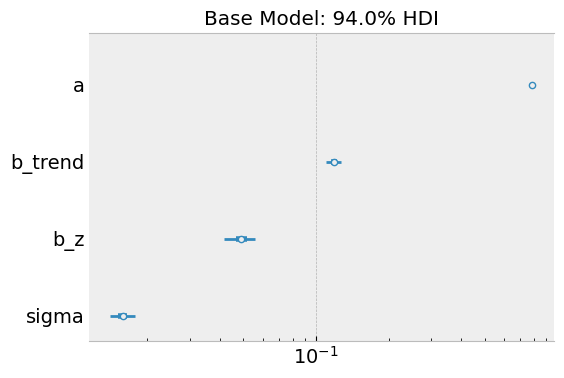

In [29]:
fig, ax = plt.subplots(figsize=(6, 4))
az.plot_forest(
    data=base_model_trace,
    var_names=["a", "b_trend", "b_z", "sigma"],
    combined=True,
    ax=ax
)
ax.set(
    title="Base Model: 94.0% HDI",
    xscale="log"
);

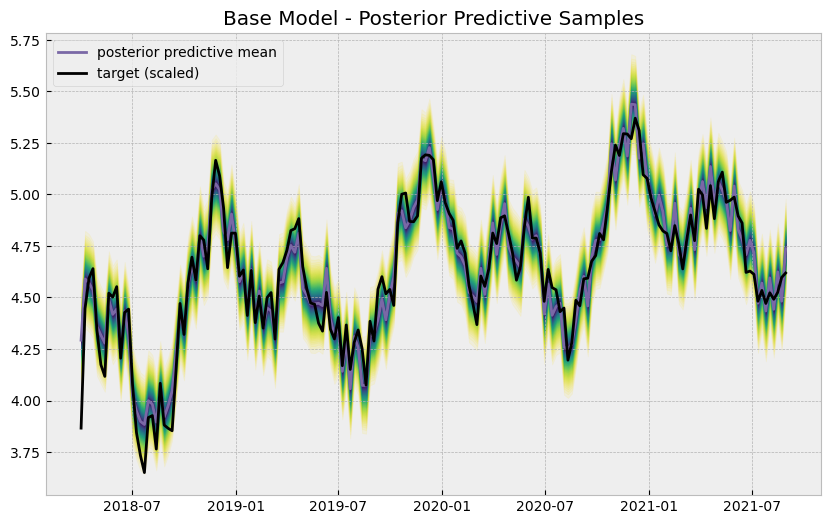

In [30]:
posterior_predictive_likelihood = az.extract(
    data=base_model_posterior_predictive,
    group="posterior_predictive",
    var_names="likelihood",
)

posterior_predictive_likelihood_inv = endog_scaler.inverse_transform(
    X=posterior_predictive_likelihood
)

fig, ax = plt.subplots()

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(posterior_predictive_likelihood_inv, p, axis=1)
    lower = np.percentile(posterior_predictive_likelihood_inv, 100 - p, axis=1)
    color_val = colors[i]
    ax.fill_between(
        x=date,
        y1=upper,
        y2=lower,
        color=cmap(color_val),
        alpha=0.1,
    )

sns.lineplot(
    x=date,
    y=posterior_predictive_likelihood_inv.mean(axis=1),
    color="C2",
    label="posterior predictive mean",
    ax=ax,
)
sns.lineplot(
    x=date,
    y=y,
    color="black",
    label="target (scaled)",
    ax=ax,
)
ax.legend(loc="upper left")
ax.set(title="Base Model - Posterior Predictive Samples");

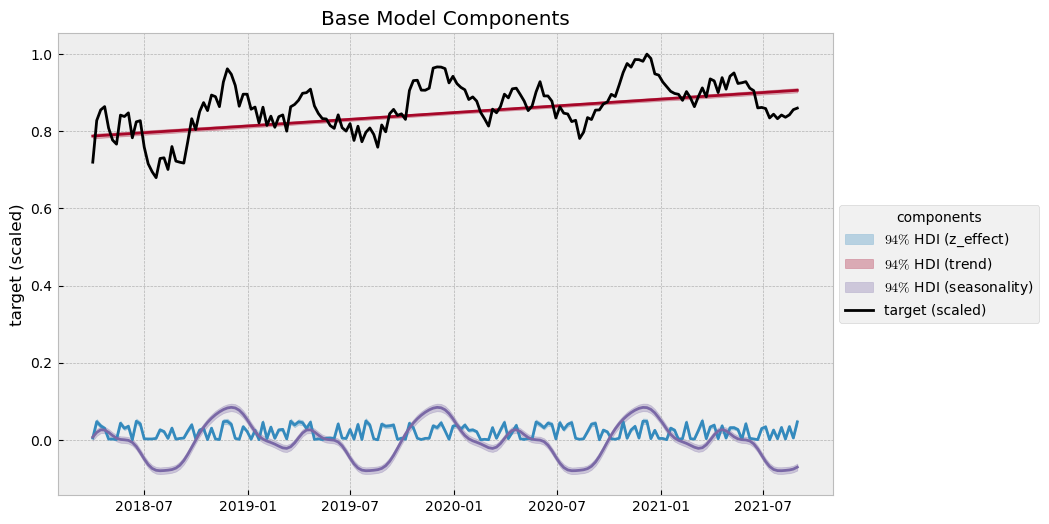

In [31]:
# compute HDI for all the model parameters
model_hdi = az.hdi(ary=base_model_trace)

fig, ax = plt.subplots()

for i, var_effect in enumerate(["z_effect", "trend", "seasonality"]):
    ax.fill_between(
        x=date,
        y1=model_hdi[var_effect][:, 0],
        y2=model_hdi[var_effect][:, 1],
        color=f"C{i}",
        alpha=0.3,
        label=f"$94\%$ HDI ({var_effect})",
    )
    sns.lineplot(
        x=date,
        y=base_model_trace.posterior[var_effect]
        .stack(sample=("chain", "draw"))
        .mean(axis=1),
        color=f"C{i}",
    )

sns.lineplot(x=date, y=y_scaled, color="black", alpha=1.0, label="target (scaled)", ax=ax)
ax.legend(title="components", loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Base Model Components", ylabel="target (scaled)");

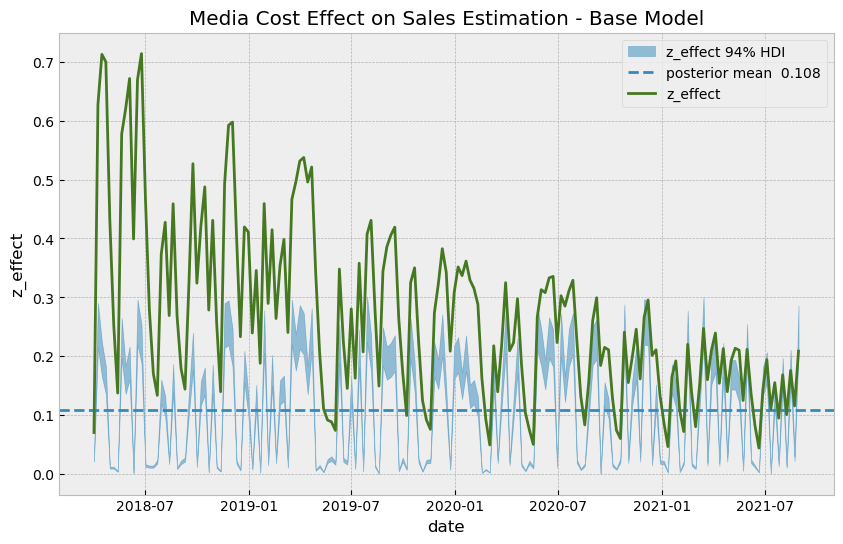

In [36]:
z_effect_posterior_samples = xr.apply_ufunc(
    lambda x: endog_scaler.inverse_transform(X=x.reshape(1, -1)),
    base_model_trace.posterior["z_effect"],
    input_core_dims=[["date"]],
    output_core_dims=[["date"]],
    vectorize=True,
)

z_effect_hdi = az.hdi(ary=z_effect_posterior_samples)["z_effect"]

fig, ax = plt.subplots()
ax.fill_between(
    x=date,
    y1=z_effect_hdi[:, 0],
    y2=z_effect_hdi[:, 1],
    color="C0",
    alpha=0.5,
    label="z_effect 94% HDI",
)
ax.axhline(
    y=z_effect_posterior_samples.mean(),
    color="C0",
    linestyle="--",
    label=f"posterior mean {z_effect_posterior_samples.mean().values: 0.3f}",
)
sns.lineplot(x="date", y="z_effect", color="C3", data=data_df, label="z_effect", ax=ax)
ax.legend(loc="upper right")
ax.set(title="Media Cost Effect on Sales Estimation - Base Model");

In [46]:
df.head()

index       date  year  month  dayofyear         z         y
0      0 2018-04-02  2018      4         92  0.936350  3.865978
1      1 2018-04-09  2018      4         99  9.507143  4.446291
2      2 2018-04-16  2018      4        106  7.319939  4.593694
3      3 2018-04-23  2018      4        113  5.986585  4.639861
4      4 2018-04-30  2018      4        120  0.390047  4.341417

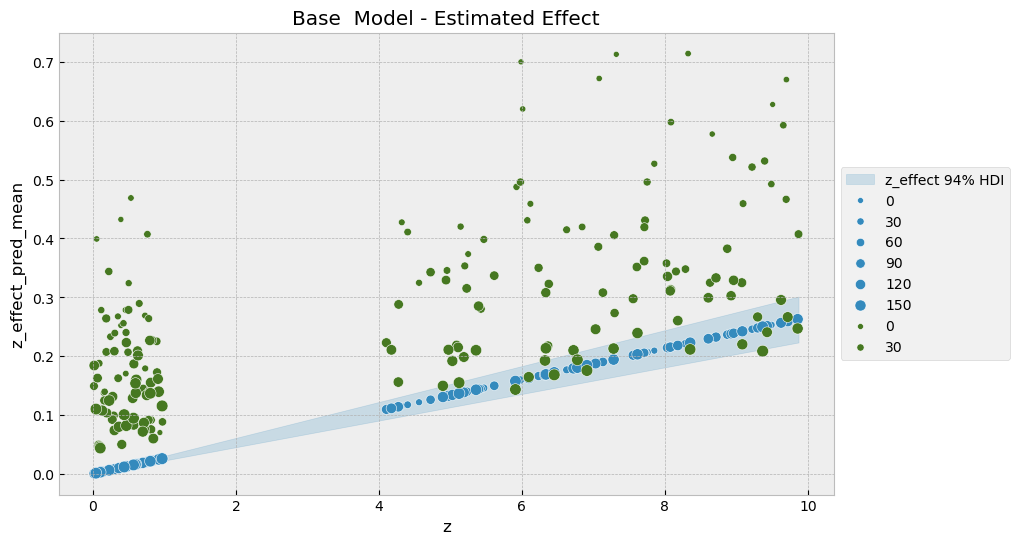

In [50]:
fig, ax = plt.subplots()

az.plot_hdi(
    x=z,
    y=z_effect_posterior_samples,
    color="C0",
    fill_kwargs={"alpha": 0.2, "label": "z_effect 94% HDI"},
    ax=ax,
)
sns.scatterplot(
    x="z",
    y="z_effect_pred_mean",
    color="C0",
    size="index",
    # label="z_effect (pred mean)",
    data=data_df.assign(
        z_effect_pred_mean=z_effect_posterior_samples.mean(dim=("chain", "draw"))
    ),
    ax=ax,
)
sns.scatterplot(
    x="z",
    y="z_effect",
    color="C3",
    size="index",
    # label="z_effect (true)",
    data=data_df,
    ax=ax,
)
h, l = ax.get_legend_handles_labels()
ax.legend(handles=h[:9], labels=l[:9], loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Base  Model - Estimated Effect");

## ROAS and mROAS

### ROAS

In [51]:
# true roas for z
roas_true = data_df["z_effect"].sum() / data_df["z"].sum()

roas_true

0.06620312360383751

In [52]:
base_model_trace_roas = base_model_trace.copy()

with base_model:
    pm.set_data(new_data={"z_scaled": np.zeros_like(a=z_scaled)})
    base_model_trace_roas.extend(
        other=pm.sample_posterior_predictive(trace=base_model_trace_roas, var_names=["likelihood"])
    )

Sampling: [likelihood]


In [53]:
base_roas_numerator = (
    endog_scaler.inverse_transform(
        X=az.extract(
            data=base_model_posterior_predictive,
            group="posterior_predictive",
            var_names=["likelihood"],
        )
    )
    - endog_scaler.inverse_transform(
        X=az.extract(
            data=base_model_trace_roas,
            group="posterior_predictive",
            var_names=["likelihood"],
        )
    )
).sum(axis=0)

roas_denominator = z.sum()

base_roas = base_roas_numerator / roas_denominator

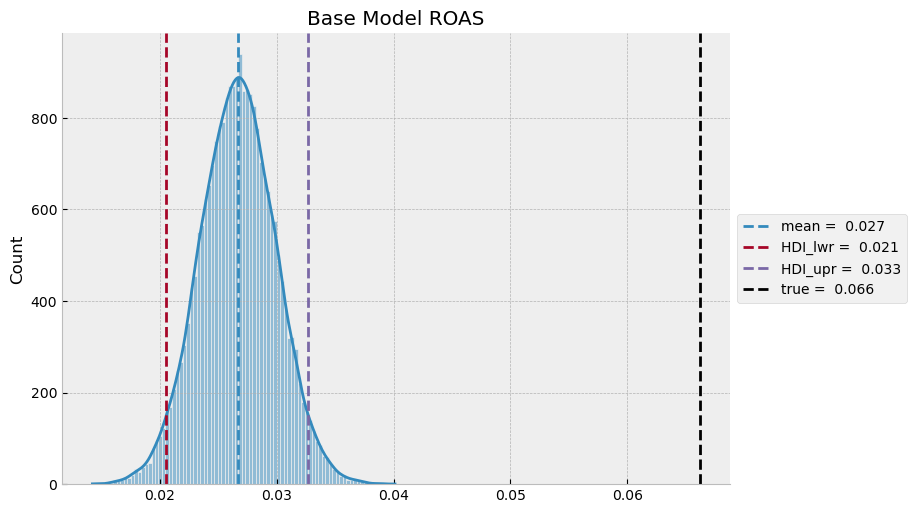

In [54]:
base_roas_mean = base_roas.mean()
base_roas_hdi = az.hdi(ary=base_roas)

g = sns.displot(x=base_roas, kde=True, height=5, aspect=1.5)
ax = g.axes.flatten()[0]
ax.axvline(
    x=base_roas_mean, color="C0", linestyle="--", label=f"mean = {base_roas_mean: 0.3f}"
)
ax.axvline(
    x=base_roas_hdi[0],
    color="C1",
    linestyle="--",
    label=f"HDI_lwr = {base_roas_hdi[0]: 0.3f}",
)
ax.axvline(
    x=base_roas_hdi[1],
    color="C2",
    linestyle="--",
    label=f"HDI_upr = {base_roas_hdi[1]: 0.3f}",
)
ax.axvline(x=roas_true, color="black", linestyle="--", label=f"true = {roas_true: 0.3f}")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Base Model ROAS");

### mROAS

In [55]:
eta: float = 0.10

base_model_trace_mroas = base_model_trace.copy()

with base_model:
    pm.set_data(new_data={"z_scaled": (1 + eta) * z_scaled})
    base_model_trace_mroas.extend(
        other=pm.sample_posterior_predictive(trace=base_model_trace_mroas, var_names=["likelihood"])
    )

Sampling: [likelihood]


In [56]:
base_mroas_numerator = (
    endog_scaler.inverse_transform(
        X=az.extract(
            data=base_model_trace_mroas,
            group="posterior_predictive",
            var_names=["likelihood"],
        )
    )
    - endog_scaler.inverse_transform(
        X=az.extract(
            data=base_model_posterior_predictive,
            group="posterior_predictive",
            var_names=["likelihood"],
        )
    )
).sum(axis=0)

mroas_denominator = eta * z.sum()

base_mroas = base_mroas_numerator / mroas_denominator

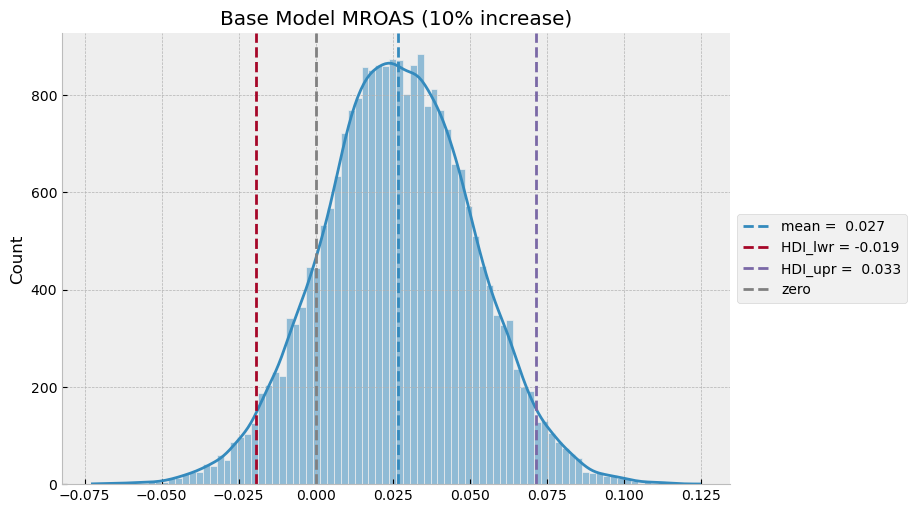

In [57]:
base_mroas_mean = base_mroas.mean()
base_mroas_hdi = az.hdi(ary=base_mroas)

g = sns.displot(x=base_mroas, kde=True, height=5, aspect=1.5)
ax = g.axes.flatten()[0]
ax.axvline(
    x=base_mroas_mean, color="C0", linestyle="--", label=f"mean = {base_mroas_mean: 0.3f}"
)
ax.axvline(
    x=base_mroas_hdi[0],
    color="C1",
    linestyle="--",
    label=f"HDI_lwr = {base_mroas_hdi[0]: 0.3f}",
)
ax.axvline(
    x=base_mroas_hdi[1],
    color="C2",
    linestyle="--",
    label=f"HDI_upr = {base_roas_hdi[1]: 0.3f}",
)
ax.axvline(x=0.0, color="gray", linestyle="--", label="zero")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title=f"Base Model MROAS ({eta:.0%} increase)");

# MODEL 2: ADSTOCK-SATURATION MODEL

In [64]:
with pm.Model(coords=coords) as adstock_saturation_model:
    # --- data containers ---
    z_scaled_ = pm.MutableData(name="z_scaled", value=z_scaled, dims="date")
    
    # --- priors ---
    ## intercept
    a = pm.Normal(name="a", mu=0, sigma=4)
    ## trend
    b_trend = pm.Normal(name="b_trend", mu=0, sigma=2)
    ## seasonality
    b_fourier = pm.Laplace(name="b_fourier", mu=0, b=2, dims="fourier_mode")
    ## adstock effect
    alpha = pm.Beta(name="alpha", alpha=1, beta=1)
    ## saturation effect
    lam = pm.Gamma(name="lam", alpha=3, beta=1)
    ## regressor
    b_z = pm.HalfNormal(name="b_z", sigma=2)
    ## standard deviation of the normal likelihood
    sigma = pm.HalfNormal(name="sigma", sigma=0.5)
    # degrees of freedom of the t distribution
    nu = pm.Gamma(name="nu", alpha=25, beta=2)

    # --- model parametrization ---
    trend = pm.Deterministic("trend", a + b_trend * t, dims="date")
    seasonality = pm.Deterministic(
        name="seasonality", var=pm.math.dot(fourier_features, b_fourier), dims="date"
    )
    z_adstock = pm.Deterministic(
        name="z_adstock", var=geometric_adstock(x=z_scaled_, alpha=alpha, l_max=12), dims="date"
    )
    z_adstock_saturated = pm.Deterministic(
        name="z_adstock_saturated",
        var=logistic_saturation(x=z_adstock, lam=lam),
        dims="date",
    )
    z_effect = pm.Deterministic(
        name="z_effect", var=b_z * z_adstock_saturated, dims="date"
    )
    mu = pm.Deterministic(name="mu", var=trend + seasonality + z_effect, dims="date")

    # --- likelihood ---
    pm.StudentT(name="likelihood", nu=nu, mu=mu, sigma=sigma, observed=y_scaled, dims="date")

    # --- prior samples
    adstock_saturation_model_prior_predictive = pm.sample_prior_predictive()

Sampling: [a, alpha, b_fourier, b_trend, b_z, lam, likelihood, nu, sigma]


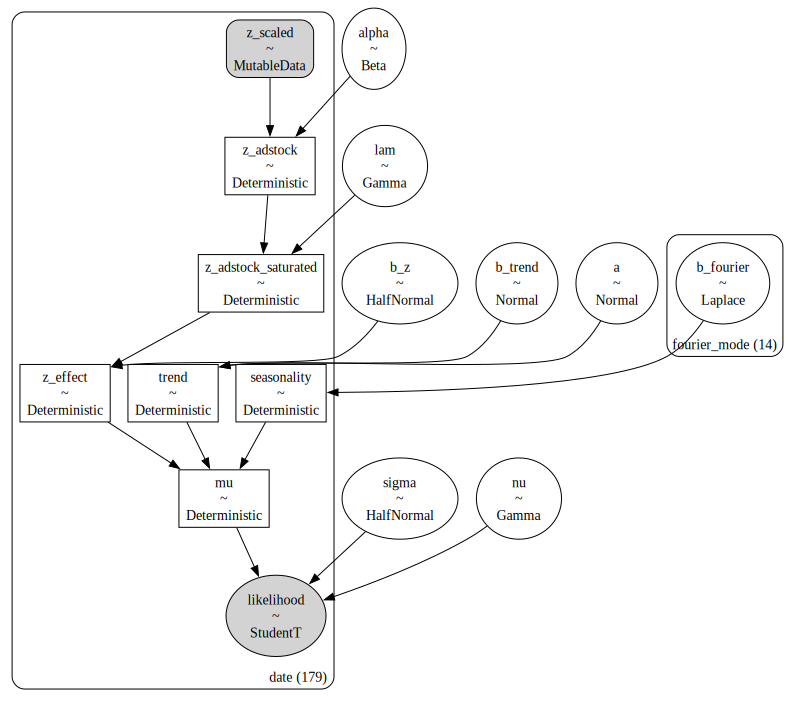

In [65]:
pm.model_to_graphviz(model=adstock_saturation_model)

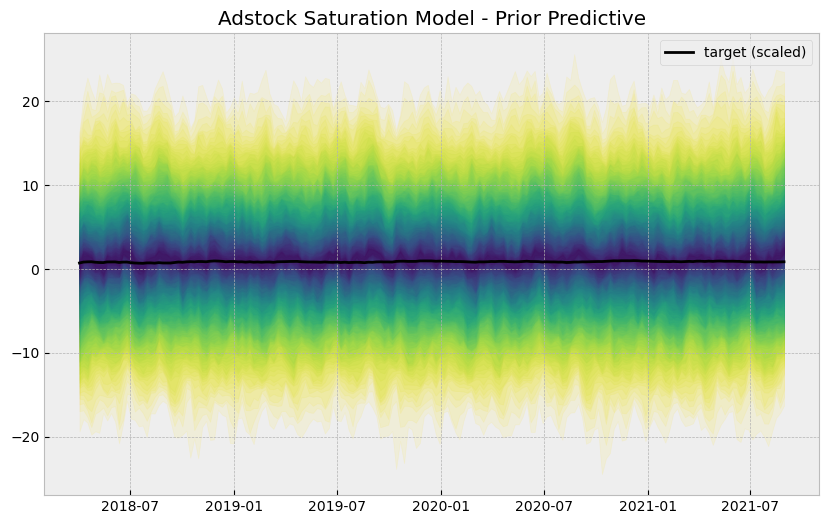

In [66]:
fig, ax = plt.subplots()

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(
        adstock_saturation_model_prior_predictive.prior_predictive["likelihood"],
        p,
        axis=1,
    )
    lower = np.percentile(
        adstock_saturation_model_prior_predictive.prior_predictive["likelihood"], 100 - p, axis=1
    )
    color_val = colors[i]
    ax.fill_between(
        x=date,
        y1=upper.flatten(),
        y2=lower.flatten(),
        color=cmap(color_val),
        alpha=0.1,
    )

sns.lineplot(x=date, y=y_scaled, color="black", label="target (scaled)", ax=ax)
ax.legend()
ax.set(title="Adstock Saturation Model - Prior Predictive");

In [67]:
with adstock_saturation_model:
    adstock_saturation_model_trace = pm.sample(
        nuts_sampler="numpyro",
        draws=6_000,
        chains=4,
        idata_kwargs={"log_likelihood": True},
    )
    adstock_saturation_model_posterior_predictive = pm.sample_posterior_predictive(
        trace=adstock_saturation_model_trace,
    )

Compiling...
Compilation time = 0:00:14.814712
Sampling...


  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

Sampling time = 0:00:19.036083
Transforming variables...
Transformation time = 0:00:01.872212
Computing Log Likelihood...
Log Likelihood time = 0:00:01.719826
Sampling: [likelihood]


In [68]:
az.summary(
    data=adstock_saturation_model_trace,
    var_names=["a", "b_trend", "b_z", "alpha", "lam", "sigma", "nu"]
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
a         0.751  0.007   0.739    0.763      0.000    0.000    5652.0   
b_trend   0.117  0.003   0.111    0.124      0.000    0.000   15072.0   
b_z       0.118  0.019   0.093    0.147      0.000    0.000    3988.0   
alpha     0.531  0.034   0.467    0.595      0.000    0.000    6285.0   
lam       1.334  0.283   0.807    1.878      0.005    0.003    3894.0   
sigma     0.012  0.001   0.010    0.013      0.000    0.000    7485.0   
nu       13.352  2.471   8.720   17.868      0.025    0.018    9771.0   

         ess_tail  r_hat  
a          7090.0    1.0  
b_trend   15474.0    1.0  
b_z        2670.0    1.0  
alpha      9246.0    1.0  
lam        2756.0    1.0  
sigma     11511.0    1.0  
nu        11941.0    1.0

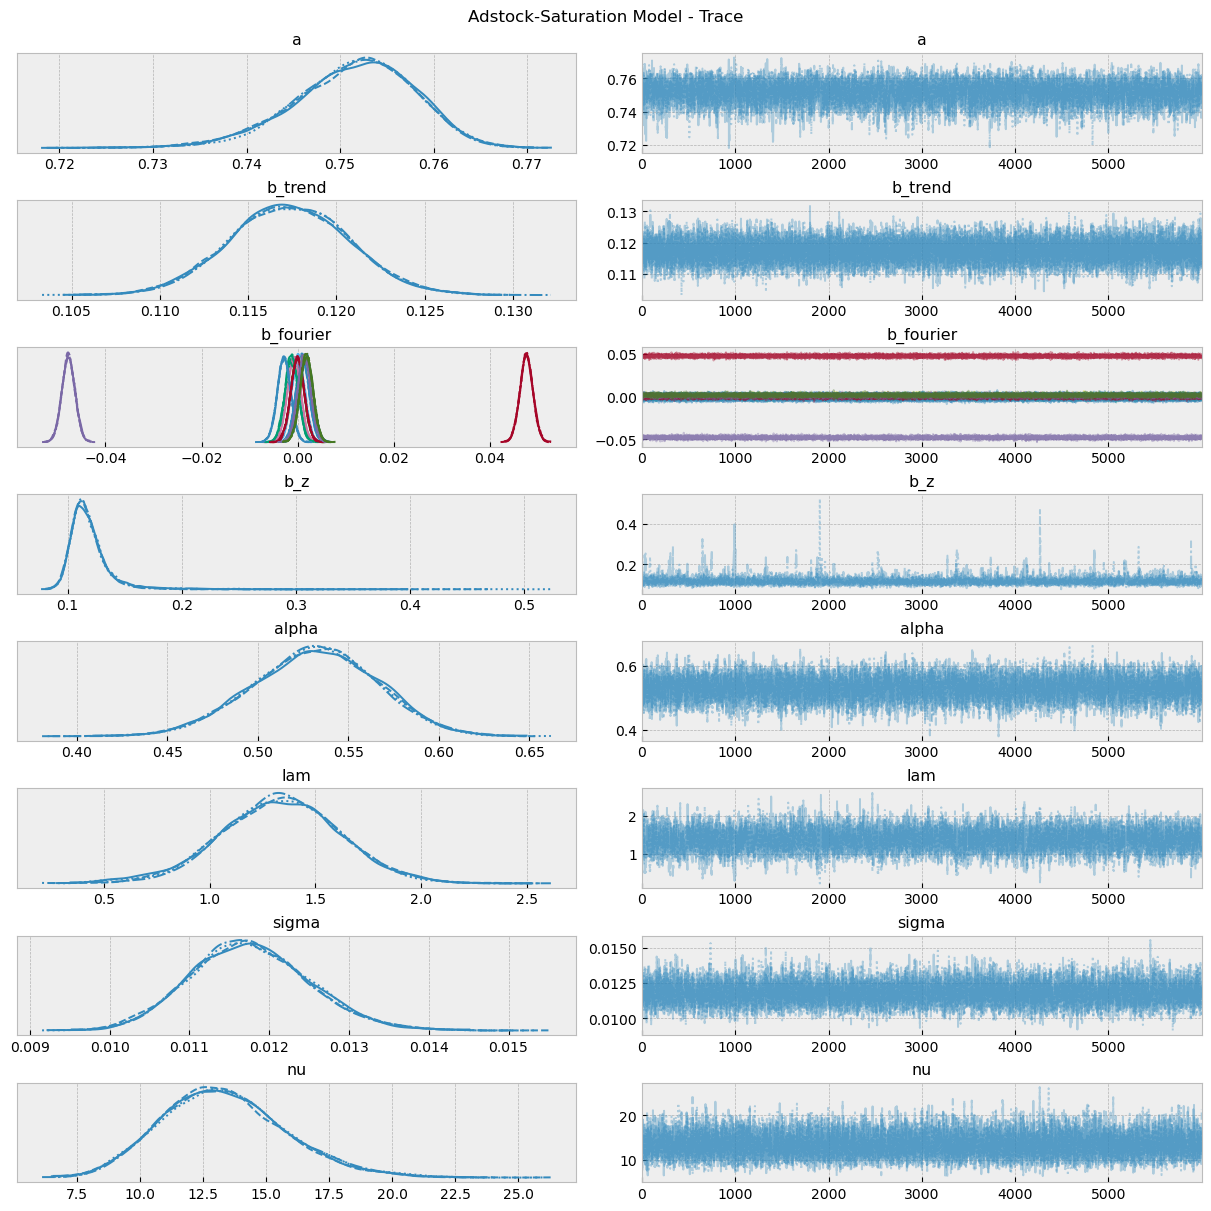

In [69]:
axes = az.plot_trace(
    data=adstock_saturation_model_trace,
    var_names=["a", "b_trend", "b_fourier", "b_z", "alpha", "lam", "sigma", "nu"],
    compact=True,
    backend_kwargs={
        "figsize": (12, 12),
        "layout": "constrained"
    },
)
fig = axes[0][0].get_figure()
fig.suptitle("Adstock-Saturation Model - Trace");

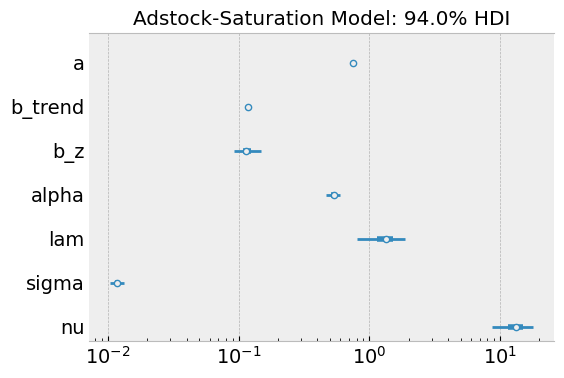

In [70]:
fig, ax = plt.subplots(figsize=(6, 4))
az.plot_forest(
    data=adstock_saturation_model_trace,
    var_names=["a", "b_trend",  "b_z", "alpha", "lam", "sigma", "nu"],
    combined=True,
    ax=ax
)
ax.set(
    title="Adstock-Saturation Model: 94.0% HDI",
    xscale="log"
);

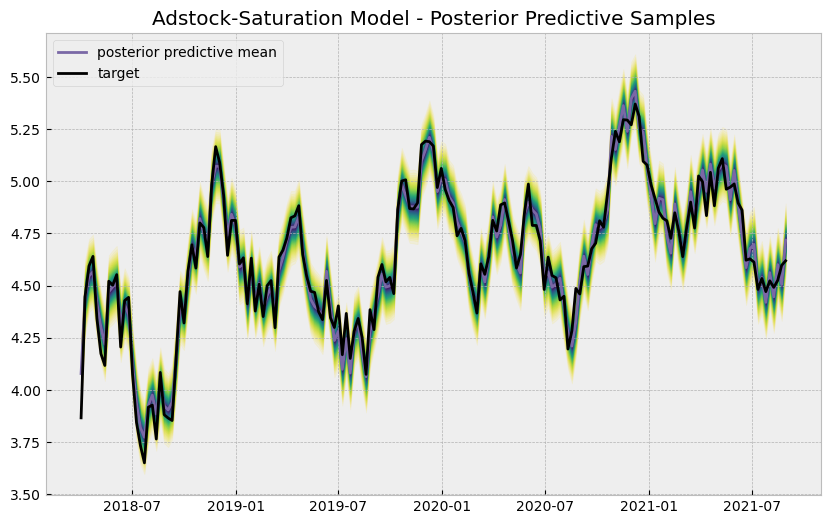

In [71]:
posterior_predictive_likelihood = az.extract(
    data=adstock_saturation_model_posterior_predictive,
    group="posterior_predictive",
    var_names="likelihood",
)

posterior_predictive_likelihood_inv = endog_scaler.inverse_transform(
    X=posterior_predictive_likelihood
)

fig, ax = plt.subplots()

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(posterior_predictive_likelihood_inv, p, axis=1)
    lower = np.percentile(posterior_predictive_likelihood_inv, 100 - p, axis=1)
    color_val = colors[i]
    ax.fill_between(
        x=date,
        y1=upper,
        y2=lower,
        color=cmap(color_val),
        alpha=0.1,
    )

sns.lineplot(
    x=date,
    y=posterior_predictive_likelihood_inv.mean(axis=1),
    color="C2",
    label="posterior predictive mean",
    ax=ax,
)
sns.lineplot(
    x=date,
    y=y,
    color="black",
    label="target",
    ax=ax,
)
ax.legend(loc="upper left")
ax.set(title="Adstock-Saturation Model - Posterior Predictive Samples");

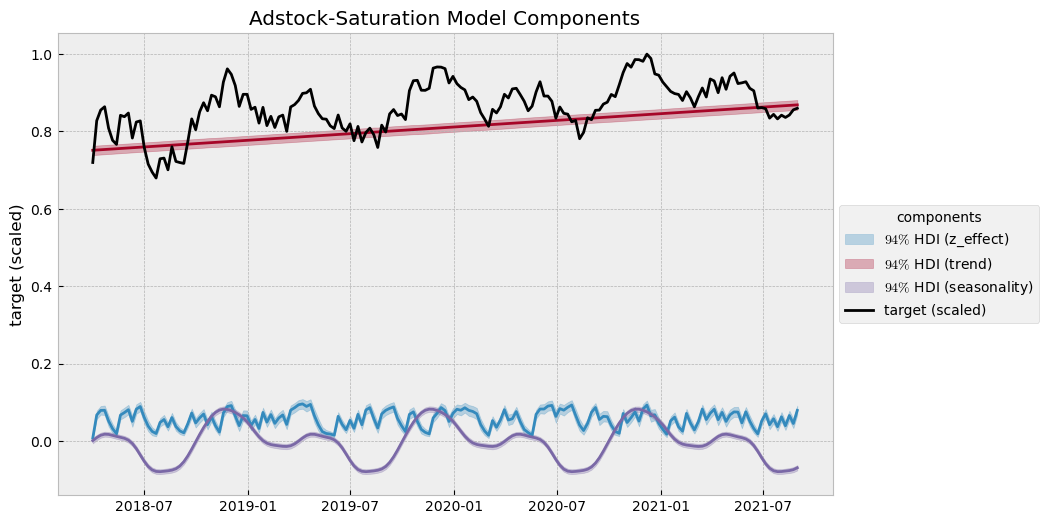

In [72]:
# compute HDI for all the model parameters
model_hdi = az.hdi(ary=adstock_saturation_model_trace)

fig, ax = plt.subplots()

for i, var_effect in enumerate(["z_effect", "trend", "seasonality"]):
    ax.fill_between(
        x=date,
        y1=model_hdi[var_effect][:, 0],
        y2=model_hdi[var_effect][:, 1],
        color=f"C{i}",
        alpha=0.3,
        label=f"$94\%$ HDI ({var_effect})",
    )
    sns.lineplot(
        x=date,
        y=adstock_saturation_model_trace.posterior[var_effect]
        .stack(sample=("chain", "draw"))
        .mean(axis=1),
        color=f"C{i}",
    )

sns.lineplot(x=date, y=y_scaled, color="black", alpha=1.0, label="target (scaled)", ax=ax)
ax.legend(title="components", loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Adstock-Saturation Model Components", ylabel="target (scaled)");

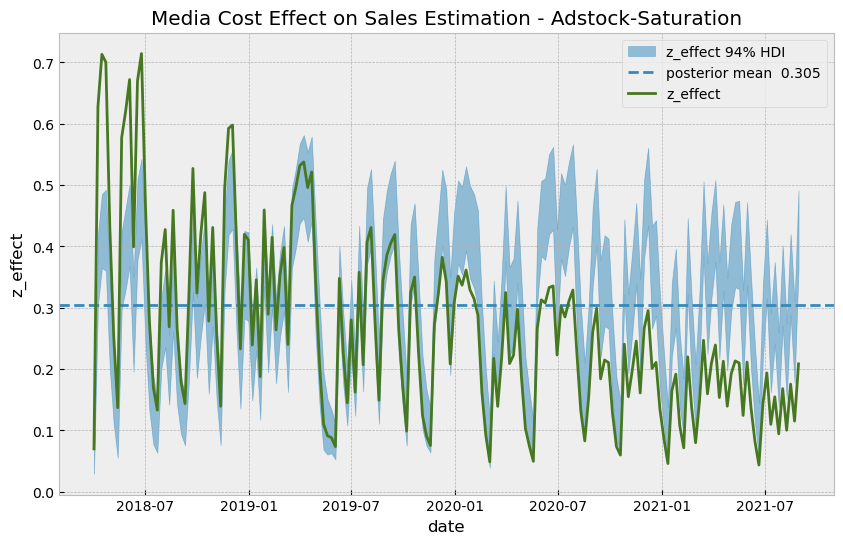

In [73]:
z_effect_posterior_samples = xr.apply_ufunc(
    lambda x: endog_scaler.inverse_transform(X=x.reshape(1, -1)),
    adstock_saturation_model_trace.posterior["z_effect"],
    input_core_dims=[["date"]],
    output_core_dims=[["date"]],
    vectorize=True,
)

z_effect_hdi = az.hdi(ary=z_effect_posterior_samples)["z_effect"]
fig, ax = plt.subplots()
ax.fill_between(
    x=date,
    y1=z_effect_hdi[:, 0],
    y2=z_effect_hdi[:, 1],
    color="C0",
    alpha=0.5,
    label="z_effect 94% HDI",
)
ax.axhline(
    y=z_effect_posterior_samples.mean(),
    color="C0",
    linestyle="--",
    label=f"posterior mean {z_effect_posterior_samples.mean().values: 0.3f}",
)
sns.lineplot(x="date", y="z_effect", color="C3", data=data_df, label="z_effect", ax=ax)
ax.legend(loc="upper right")
ax.set(title="Media Cost Effect on Sales Estimation - Adstock-Saturation");

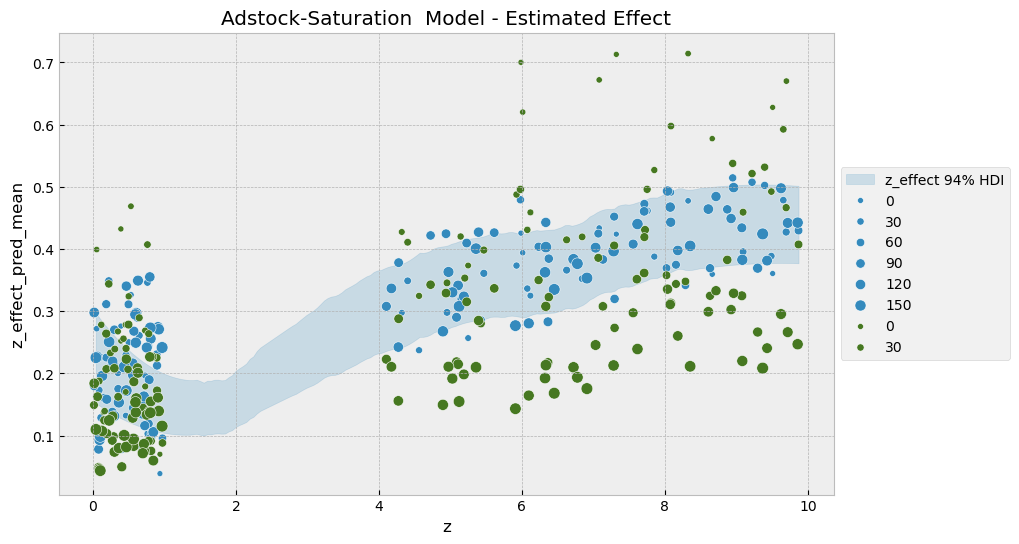

In [74]:
fig, ax = plt.subplots()

az.plot_hdi(
    x=z,
    y=z_effect_posterior_samples,
    color="C0",
    fill_kwargs={"alpha": 0.2, "label": "z_effect 94% HDI"},
    ax=ax,
)
sns.scatterplot(
    x="z",
    y="z_effect_pred_mean",
    color="C0",
    size="index",
    # label="z_effect (pred mean)",
    data=data_df.assign(
        z_effect_pred_mean=z_effect_posterior_samples.mean(dim=("chain", "draw"))
    ),
    ax=ax,
)
sns.scatterplot(
    x="z",
    y="z_effect",
    color="C3",
    size="index",
    # label="z_effect (true)",
    data=data_df,
    ax=ax,
)
h, l = ax.get_legend_handles_labels()
ax.legend(handles=h[:9], labels=l[:9], loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Adstock-Saturation  Model - Estimated Effect");

## ROAS and mROAS

### ROAS

In [75]:
adstock_saturation_model_trace_roas = adstock_saturation_model_trace.copy()

with adstock_saturation_model:
    pm.set_data(new_data={"z_scaled": np.zeros_like(a=z_scaled)})
    adstock_saturation_model_trace_roas.extend(
        other=pm.sample_posterior_predictive(trace=adstock_saturation_model_trace_roas, var_names=["likelihood"])
    )

Sampling: [likelihood]


In [76]:
adstock_saturation_roas_numerator = (
    endog_scaler.inverse_transform(
        X=az.extract(
            data=adstock_saturation_model_posterior_predictive,
            group="posterior_predictive",
            var_names=["likelihood"],
        )
    )
    - endog_scaler.inverse_transform(
        X=az.extract(
            data=adstock_saturation_model_trace_roas,
            group="posterior_predictive",
            var_names=["likelihood"],
        )
    )
).sum(axis=0)

roas_denominator = z.sum()

adstock_saturation_roas = adstock_saturation_roas_numerator / roas_denominator

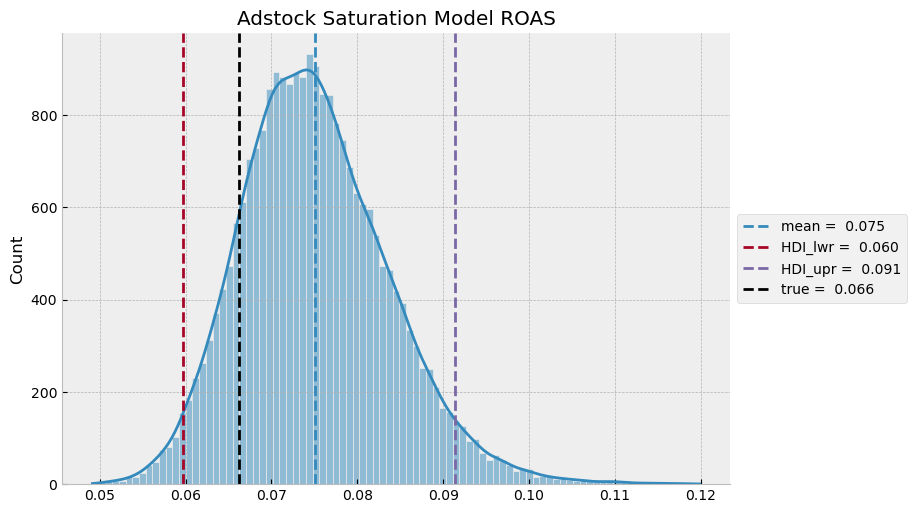

In [77]:
adstock_saturation_roas_mean = adstock_saturation_roas.mean()
adstock_saturation_roas_hdi = az.hdi(ary=adstock_saturation_roas)

g = sns.displot(x=adstock_saturation_roas, kde=True, height=5, aspect=1.5)
ax = g.axes.flatten()[0]
ax.axvline(
    x=adstock_saturation_roas_mean, color="C0", linestyle="--", label=f"mean = {adstock_saturation_roas_mean: 0.3f}"
)
ax.axvline(
    x=adstock_saturation_roas_hdi[0],
    color="C1",
    linestyle="--",
    label=f"HDI_lwr = {adstock_saturation_roas_hdi[0]: 0.3f}",
)
ax.axvline(
    x=adstock_saturation_roas_hdi[1],
    color="C2",
    linestyle="--",
    label=f"HDI_upr = {adstock_saturation_roas_hdi[1]: 0.3f}",
)
ax.axvline(x=roas_true, color="black", linestyle="--", label=f"true = {roas_true: 0.3f}")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Adstock Saturation Model ROAS");

### mROAS

In [78]:
b_z_true = (np.arange(start=0.0, stop=1.0, step=1/n_obs) + 1) ** (-1.8)

z_effect_eta = b_z_true * logistic_saturation(
    x=geometric_adstock(x=(1 + eta) * z, alpha=0.5, l_max=12),
    lam=0.15
).eval()

mroas_true = (z_effect_eta - data_df["z_effect"]).sum() / ( eta * z.sum())

mroas_true

0.045259246530653344

In [79]:
eta: float = 0.10

adstock_saturation_model_trace_mroas = adstock_saturation_model_trace.copy()

with adstock_saturation_model:
    pm.set_data(new_data={"z_scaled": (1 + eta) * z_scaled})
    adstock_saturation_model_trace_mroas.extend(
        other=pm.sample_posterior_predictive(trace=adstock_saturation_model_trace_mroas, var_names=["likelihood"])
    )

Sampling: [likelihood]


In [80]:
adstock_saturation_mroas_numerator = (
    endog_scaler.inverse_transform(
        X=az.extract(
            data=adstock_saturation_model_trace_mroas,
            group="posterior_predictive",
            var_names=["likelihood"],
        )
    )
    - endog_scaler.inverse_transform(
        X=az.extract(
            data=adstock_saturation_model_posterior_predictive,
            group="posterior_predictive",
            var_names=["likelihood"],
        )
    )
).sum(axis=0)

mroas_denominator = eta * z.sum()

adstock_saturation_mroas = adstock_saturation_mroas_numerator / mroas_denominator

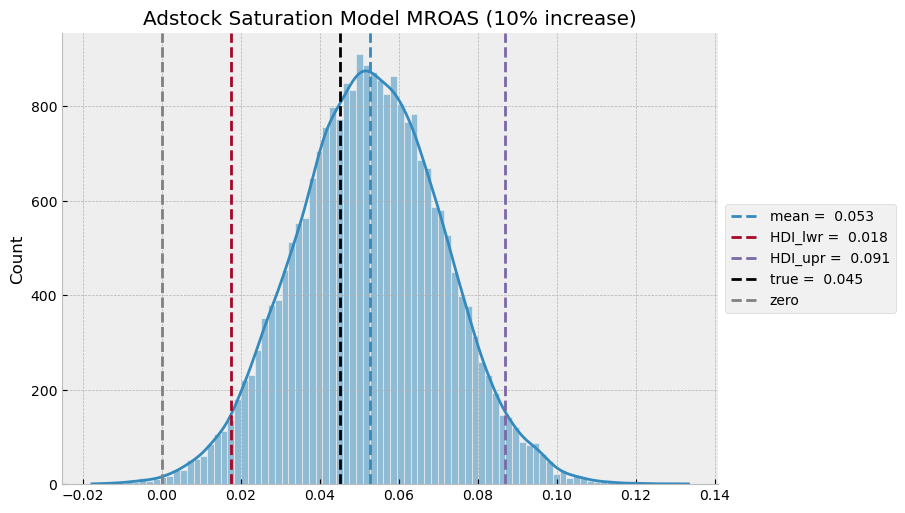

In [82]:
adstock_saturation_mroas_mean = adstock_saturation_mroas.mean()
adstock_saturation_mroas_hdi = az.hdi(ary=adstock_saturation_mroas)

g = sns.displot(x=adstock_saturation_mroas, kde=True, height=5, aspect=1.5)
ax = g.axes.flatten()[0]
ax.axvline(
    x=adstock_saturation_mroas_mean, color="C0", linestyle="--", label=f"mean = {adstock_saturation_mroas_mean: 0.3f}"
)
ax.axvline(
    x=adstock_saturation_mroas_hdi[0],
    color="C1",
    linestyle="--",
    label=f"HDI_lwr = {adstock_saturation_mroas_hdi[0]: 0.3f}",
)
ax.axvline(
    x=adstock_saturation_mroas_hdi[1],
    color="C2",
    linestyle="--",
    label=f"HDI_upr = {adstock_saturation_roas_hdi[1]: 0.3f}",
)
ax.axvline(x=mroas_true, color="black", linestyle="--", label=f"true = {mroas_true: 0.3f}")
ax.axvline(x=0.0, color="gray", linestyle="--", label="zero")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title=f"Adstock Saturation Model MROAS ({eta:.0%} increase)");

# Model 3: ADSTOCK-SATURATION-DIMINISHING RETURNS MODEL

Sampling: [a, alpha, b_fourier, b_trend, lam, likelihood, nu, sigma, sigma_slope, slopes]


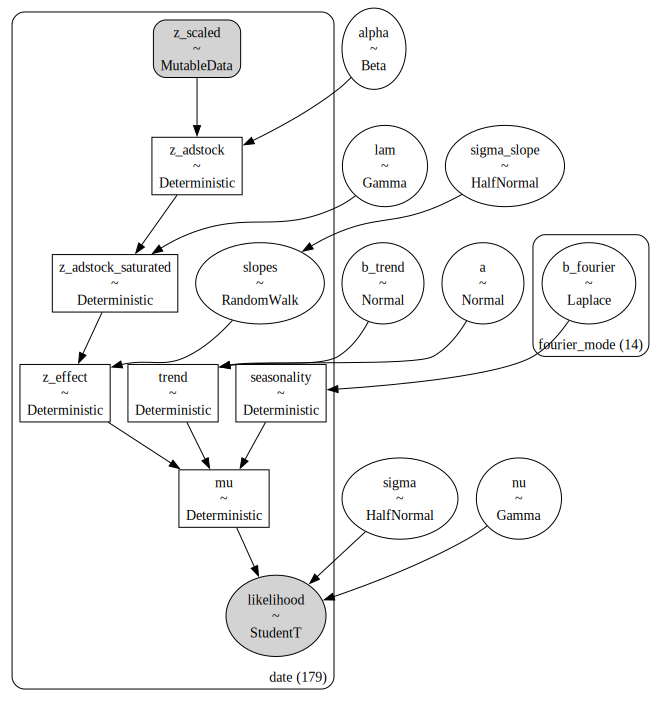

In [83]:
with pm.Model(coords=coords) as asdr_model:
    # --- data containers ---
    z_scaled_ = pm.MutableData(name="z_scaled", value=z_scaled, dims="date")

    # --- priors ---
    ## intercept
    a = pm.Normal(name="a", mu=0, sigma=4)
    ## trend
    b_trend = pm.Normal(name="b_trend", mu=0, sigma=2)
    ## seasonality
    b_fourier = pm.Laplace(name="b_fourier", mu=0, b=2, dims="fourier_mode")
    ## adstock effect
    alpha = pm.Beta(name="alpha", alpha=1, beta=1)
    ## saturation effect
    lam = pm.Gamma(name="lam", alpha=1, beta=1)
    ## gaussian random walk standard deviation
    sigma_slope = pm.HalfNormal(name="sigma_slope", sigma=0.05)
    ## standard deviation of the normal likelihood
    sigma = pm.HalfNormal(name="sigma", sigma=0.5)
    # degrees of freedom of the t distribution
    nu = pm.Gamma(name="nu", alpha=10, beta=1)

    # --- model parametrization ---
    trend = pm.Deterministic(name="trend", var=a + b_trend * t, dims="date")
    seasonality = pm.Deterministic(
        name="seasonality", var=pm.math.dot(fourier_features, b_fourier), dims="date"
    )
    slopes = pm.GaussianRandomWalk(
        name="slopes",
        sigma=sigma_slope,
        init_dist=pm.distributions.continuous.Normal.dist(
            name="init_dist", mu=0, sigma=2
        ),
        dims="date",
    )
    z_adstock = pm.Deterministic(
        name="z_adstock", var=geometric_adstock(x=z_scaled_, alpha=alpha, l_max=12), dims="date"
    )
    z_adstock_saturated = pm.Deterministic(
        name="z_adstock_saturated",
        var=logistic_saturation(x=z_adstock, lam=lam),
        dims="date",
    )
    z_effect = pm.Deterministic(
        name="z_effect", var=pm.math.exp(slopes) * z_adstock_saturated, dims="date"
    )
    mu = pm.Deterministic(name="mu", var=trend + seasonality + z_effect, dims="date")

    # --- likelihood ---
    pm.StudentT(name="likelihood", nu=nu, mu=mu, sigma=sigma, observed=y_scaled, dims="date")

    # --- prior samples ---
    asdr_model_prior_predictive = pm.sample_prior_predictive()

pm.model_to_graphviz(model=asdr_model)

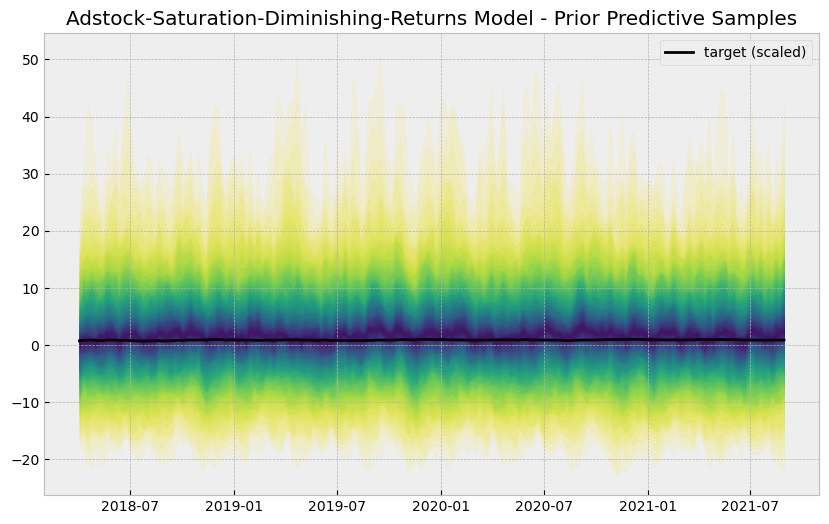

In [84]:
fig, ax = plt.subplots()

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(
        asdr_model_prior_predictive.prior_predictive["likelihood"],
        p,
        axis=1,
    )
    lower = np.percentile(
        asdr_model_prior_predictive.prior_predictive["likelihood"], 100 - p, axis=1
    )
    color_val = colors[i]
    ax.fill_between(
        x=date,
        y1=upper.flatten(),
        y2=lower.flatten(),
        color=cmap(color_val),
        alpha=0.1,
    )

sns.lineplot(x=date, y=y_scaled, color="black", label="target (scaled)", ax=ax)
ax.legend()
ax.set(title="Adstock-Saturation-Diminishing-Returns Model - Prior Predictive Samples");

In [85]:
with asdr_model:
    asdr_model_trace = pm.sample(
        nuts_sampler="numpyro",
        draws=6_000,
        chains=4,
        idata_kwargs={"log_likelihood": True},
    )
    asdr_model_posterior_predictive = pm.sample_posterior_predictive(
        trace=asdr_model_trace
    )

Compiling...
Compilation time = 0:00:15.085889
Sampling...


  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

Sampling time = 0:00:53.197119
Transforming variables...
Transformation time = 0:00:01.302154
Computing Log Likelihood...
Log Likelihood time = 0:00:02.240206
Sampling: [likelihood]


In [86]:
az.summary(
    data=asdr_model_trace,
    var_names=["a", "b_trend", "sigma_slope", "alpha", "lam", "sigma", "nu"]
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
a             0.720  0.006   0.708    0.732      0.000    0.000    8306.0   
b_trend       0.184  0.008   0.169    0.199      0.000    0.000    3163.0   
sigma_slope   0.040  0.009   0.024    0.058      0.000    0.000     788.0   
alpha         0.510  0.027   0.457    0.560      0.001    0.000    2854.0   
lam           1.577  0.251   1.114    2.050      0.007    0.005    1285.0   
sigma         0.008  0.001   0.007    0.010      0.000    0.000   11357.0   
nu           11.339  3.098   5.895   17.166      0.019    0.014   24544.0   

             ess_tail  r_hat  
a             13632.0    1.0  
b_trend        5483.0    1.0  
sigma_slope    1826.0    1.0  
alpha          6095.0    1.0  
lam            1275.0    1.0  
sigma         15734.0    1.0  
nu            16868.0    1.0

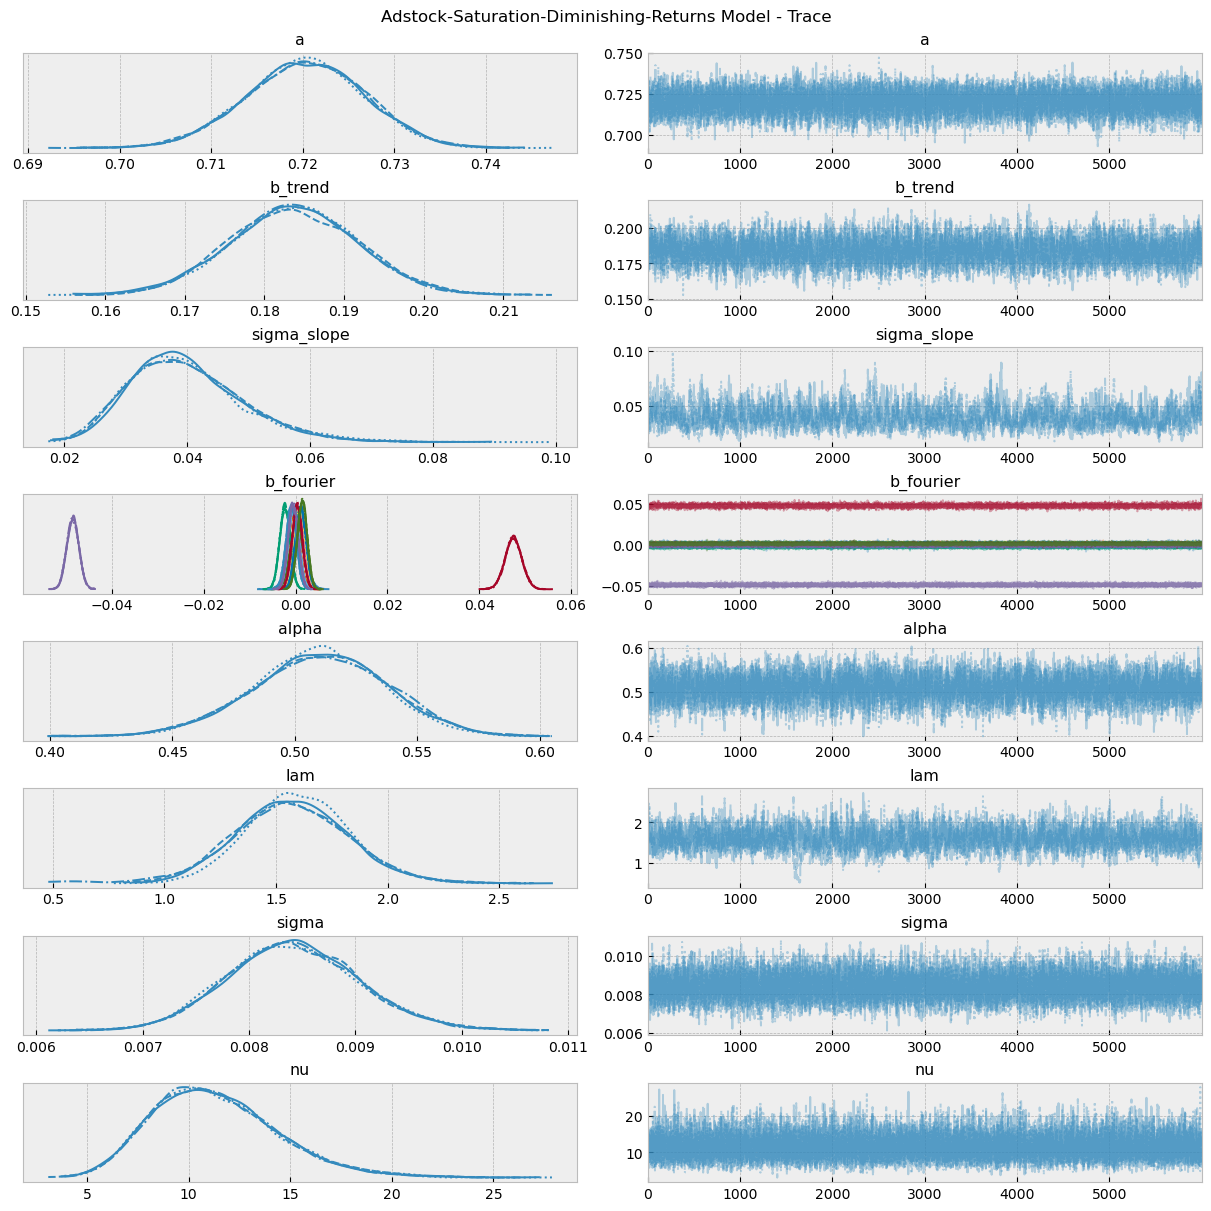

In [87]:
axes = az.plot_trace(
    data=asdr_model_trace,
    var_names=[
        "a",
        "b_trend",
        "sigma_slope",
        "b_fourier",
        "alpha",
        "lam",
        "sigma",
        "nu",
    ],
    compact=True,
    backend_kwargs={"figsize": (12, 12), "layout": "constrained"},
)
fig = axes[0][0].get_figure()
fig.suptitle("Adstock-Saturation-Diminishing-Returns Model - Trace");

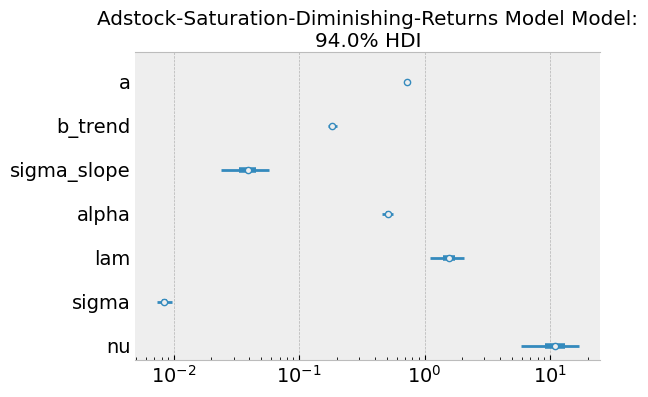

In [88]:
fig, ax = plt.subplots(figsize=(6, 4))
az.plot_forest(
    data=asdr_model_trace,
    var_names=["a", "b_trend", "sigma_slope", "alpha", "lam", "sigma", "nu"],
    combined=True,
    ax=ax
)
ax.set(
    title="Adstock-Saturation-Diminishing-Returns Model Model: 94.0% HDI",
    xscale="log"
);

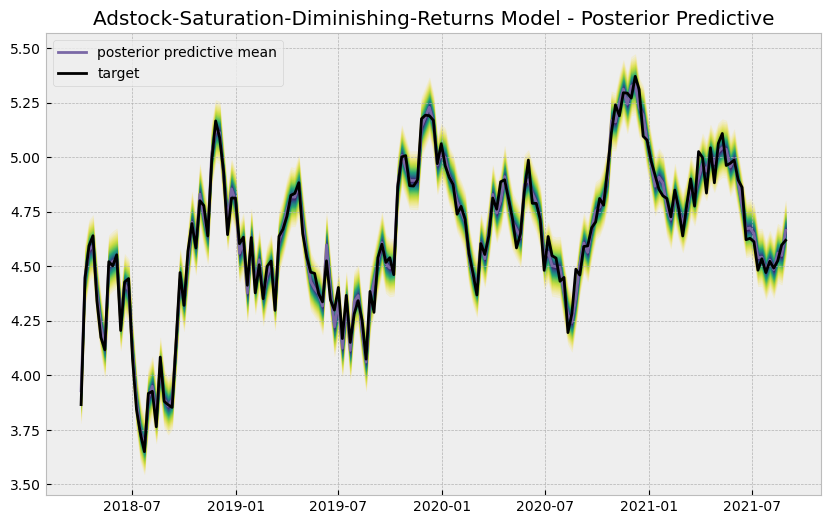

In [89]:
posterior_predictive_likelihood = az.extract(
    data=asdr_model_posterior_predictive,
    group="posterior_predictive",
    var_names="likelihood",
)

posterior_predictive_likelihood_inv = endog_scaler.inverse_transform(
    X=posterior_predictive_likelihood
)

fig, ax = plt.subplots()

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(posterior_predictive_likelihood_inv, p, axis=1)
    lower = np.percentile(posterior_predictive_likelihood_inv, 100 - p, axis=1)
    color_val = colors[i]
    ax.fill_between(
        x=date,
        y1=upper,
        y2=lower,
        color=cmap(color_val),
        alpha=0.1,
    )

sns.lineplot(
    x=date,
    y=posterior_predictive_likelihood_inv.mean(axis=1),
    color="C2",
    label="posterior predictive mean",
    ax=ax,
)
sns.lineplot(
    x=date,
    y=y,
    color="black",
    label="target",
    ax=ax,
)
ax.legend(loc="upper left")
ax.set(title="Adstock-Saturation-Diminishing-Returns Model - Posterior Predictive");

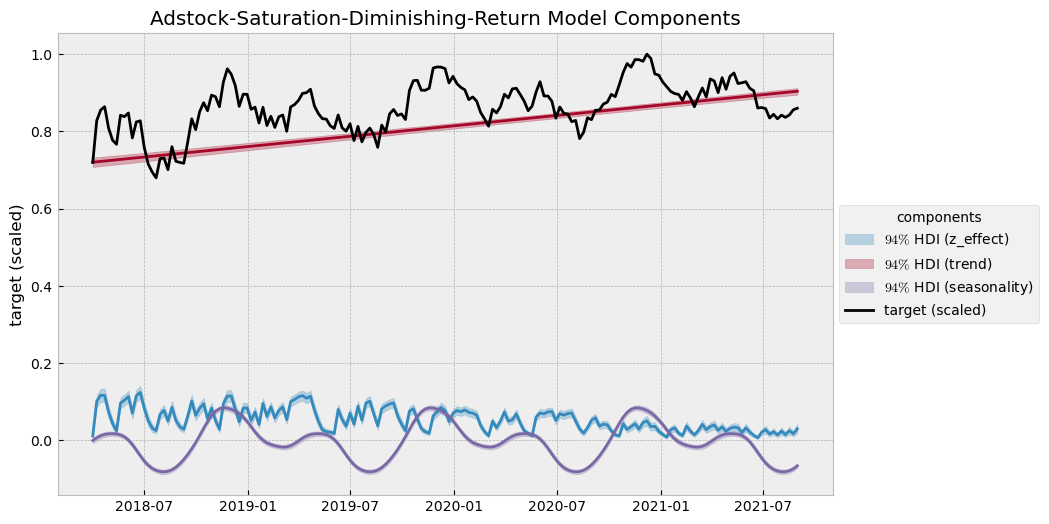

In [90]:
# compute HDI for all the model parameters
model_hdi = az.hdi(ary=asdr_model_trace)

fig, ax = plt.subplots()

for i, var_effect in enumerate(["z_effect", "trend", "seasonality"]):
    ax.fill_between(
        x=date,
        y1=model_hdi[var_effect][:, 0],
        y2=model_hdi[var_effect][:, 1],
        color=f"C{i}",
        alpha=0.3,
        label=f"$94\%$ HDI ({var_effect})",
    )
    sns.lineplot(
        x=date,
        y=asdr_model_trace.posterior[var_effect]
        .stack(sample=("chain", "draw"))
        .mean(axis=1),
        color=f"C{i}",
    )

sns.lineplot(
    x=date, y=y_scaled, color="black", alpha=1.0, label="target (scaled)", ax=ax
)
ax.legend(title="components", loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(
    title="Adstock-Saturation-Diminishing-Return Model Components",
    ylabel="target (scaled)",
);

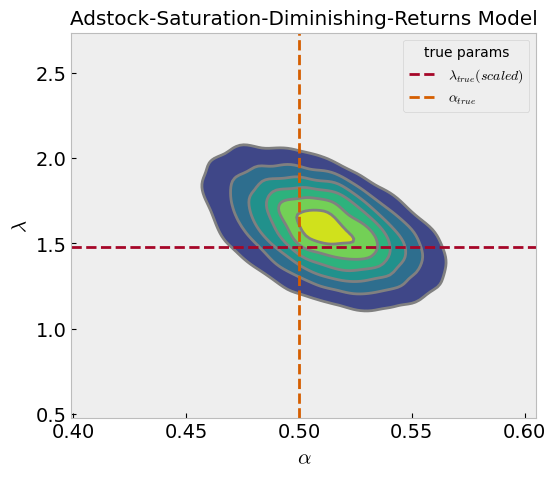

In [91]:
alpha_true = 0.5
lam_true = 0.15
lam_true_scaled = 0.15 * channel_scaler.scale_.item()

fig, ax = plt.subplots(figsize=(6, 5))
az.plot_pair(
    data=asdr_model_trace,
    var_names=["alpha", "lam"],
    kind="kde",
    divergences=True,
    ax=ax
)
ax.axhline(lam_true_scaled, color="C1", linestyle="--", label="$\lambda_{true} (scaled)$")
ax.axvline(alpha_true, color="C4", linestyle="--", label="$\\alpha_{true}$")
ax.legend(title="true params", loc="upper right")
ax.set(
    title="Adstock-Saturation-Diminishing-Returns Model",
    xlabel="$\\alpha$",
    ylabel="$\lambda$"
);

In [94]:
corr, _ = pearsonr(
    x=asdr_model_trace.posterior["alpha"].stack(sample=("chain", "draw")).to_numpy(),
    y=asdr_model_trace.posterior["lam"].stack(sample=("chain", "draw")).to_numpy()
)

print(f"Correlation between alpha and lambda {corr: 0.3f}");

Correlation between alpha and lambda -0.474


In [95]:
alpha_posterior = az.extract(data=asdr_model_trace, group="posterior", var_names="alpha")

alpha_posterior_samples = alpha_posterior.to_numpy()[:100]

# pass z through the adstock transformation
geometric_adstock_posterior_samples = np.array([
    geometric_adstock(x=z, alpha=x).eval()
    for x in alpha_posterior_samples
])

C:\Users\migue\AppData\Local\Temp\ipykernel_30344\797217844.py:1: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  geometric_adstock_hdi = az.hdi(ary=geometric_adstock_posterior_samples)


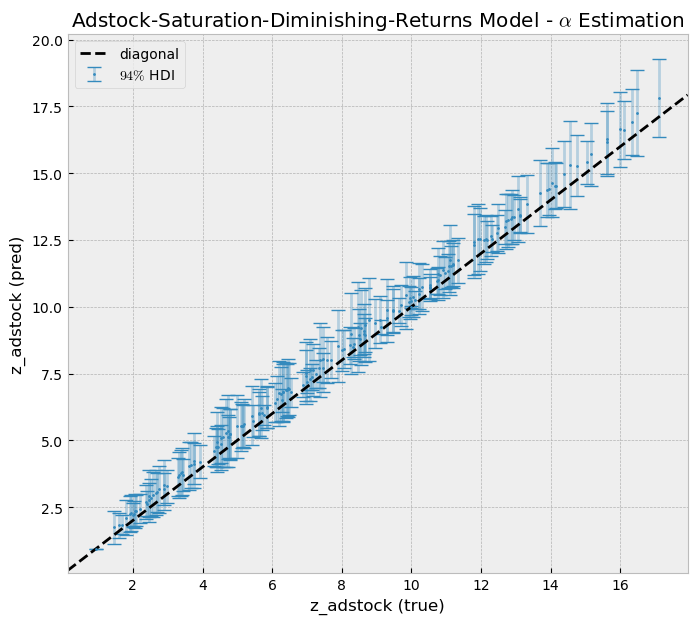

In [96]:
geometric_adstock_hdi = az.hdi(ary=geometric_adstock_posterior_samples)

yerr = geometric_adstock_hdi[:, 1] - geometric_adstock_hdi[:, 0]

fig, ax = plt.subplots(figsize=(8, 7))

markers, caps, bars = ax.errorbar(
    x=data_df["z_adstock"], 
    y=geometric_adstock_posterior_samples.mean(axis=0), 
    yerr=yerr/2,
    color="C0",
    fmt='o',
    ms=1,
    capsize=5,
    label="$94\%$ HDI",
)
[bar.set_alpha(0.3) for bar in bars]
ax.axline(
    xy1=(10, 10),
    slope=1.0,
    color="black",
    linestyle="--",
    label="diagonal"
)
ax.legend()
ax.set(
    title="Adstock-Saturation-Diminishing-Returns Model - $\\alpha$ Estimation",
    xlabel="z_adstock (true)",
    ylabel="z_adstock (pred)",
);

In [97]:
lam_posterior = (
    az.extract(data=asdr_model_trace, group="posterior", var_names="lam")
    / channel_scaler.scale_.item()
)

lam_posterior_samples = lam_posterior.to_numpy()[:100]

logistic_saturation_posterior_samples = np.array(
    [
        logistic_saturation(x=x, lam=lam_posterior_samples).eval()
        for x in data_df["z_adstock"].values
    ]
)

C:\Users\migue\AppData\Local\Temp\ipykernel_30344\1422980558.py:1: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  logistic_saturation_hdi = az.hdi(ary=logistic_saturation_posterior_samples.T)


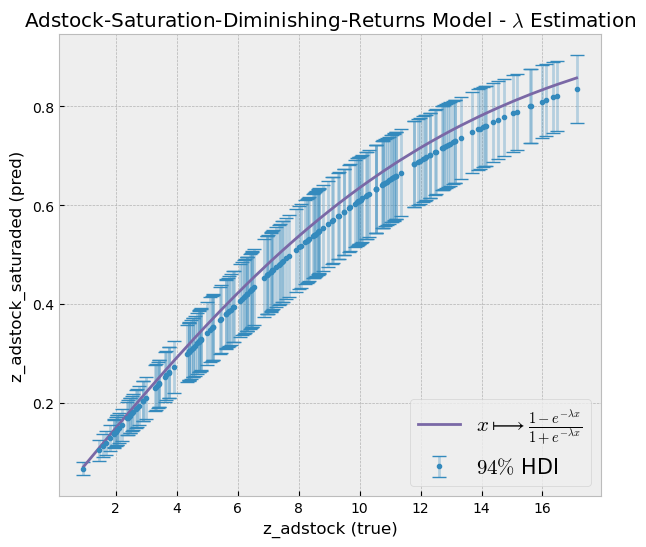

In [98]:
logistic_saturation_hdi = az.hdi(ary=logistic_saturation_posterior_samples.T)

yerr = logistic_saturation_hdi[:, 1] - logistic_saturation_hdi[:, 0]


fig, ax = plt.subplots(figsize=(7, 6))

latex_function = r"$x\longmapsto \frac{1 - e^{-\lambda x}}{1 + e^{-\lambda x}}$"

markers, caps, bars = ax.errorbar(
    x=data_df["z_adstock"], 
    y=logistic_saturation_posterior_samples.mean(axis=1), 
    yerr=yerr/2,
    color="C0",
    fmt='o',
    ms=3,
    capsize=5,
    label="$94\%$ HDI",
)
[bar.set_alpha(0.3) for bar in bars]
sns.lineplot(
    x="z_adstock",
    y="z_adstock_saturated",
    color="C2",
    label=latex_function,
    data=data_df,
    ax=ax
)
ax.legend(loc="lower right", prop={"size": 15})
ax.set(
    title="Adstock-Saturation-Diminishing-Returns Model - $\lambda$ Estimation",
    xlabel="z_adstock (true)",
    ylabel="z_adstock_saturaded (pred)",
);

C:\Users\migue\AppData\Local\Temp\ipykernel_30344\1833649741.py:20: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  var_name_hdi =az.hdi(ary=var_name_posterior.T)
C:\Users\migue\AppData\Local\Temp\ipykernel_30344\1833649741.py:20: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  var_name_hdi =az.hdi(ary=var_name_posterior.T)
C:\Users\migue\AppData\Local\Temp\ipykernel_30344\1833649741.py:20: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  var_name_hdi =az.hdi(ary=var_name_posterior.T)


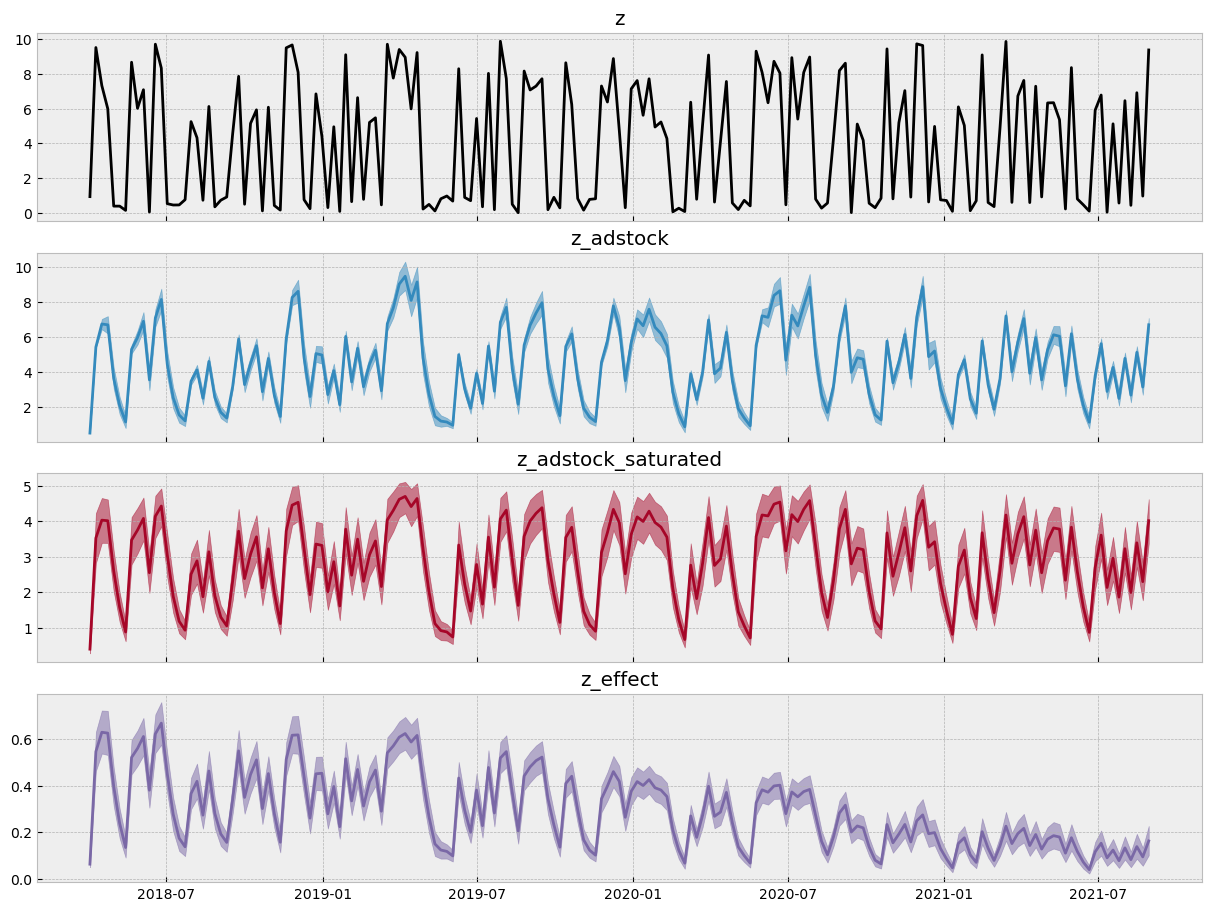

In [99]:
model_hdi_inv = az.hdi(ary=asdr_model_trace)

fig, axes = plt.subplots(
    nrows=4, ncols=1, figsize=(12, 9), sharex=True, sharey=False, layout="constrained"
)

sns.lineplot(
    x=date,
    y=z,
    color="black",
    ax=axes[0],
)
axes[0].set(title="z")

for i, var_name in enumerate(["z_adstock", "z_adstock_saturated", "z_effect"]):

    var_name_posterior = endog_scaler.inverse_transform(
            X=az.extract(data=asdr_model_trace, group="posterior", var_names=var_name)
        )
    var_name_hdi =az.hdi(ary=var_name_posterior.T)

    ax = axes[i + 1]
    sns.lineplot(
        x=date,
        y=var_name_posterior.mean(axis=1),
        color=f"C{i}",
        ax=ax,
    )
    ax.fill_between(
        x=date,
        y1=var_name_hdi[:, 0],
        y2=var_name_hdi[:, 1],
        color=f"C{i}",
        alpha=0.5,
    )
    ax.set(title=var_name)

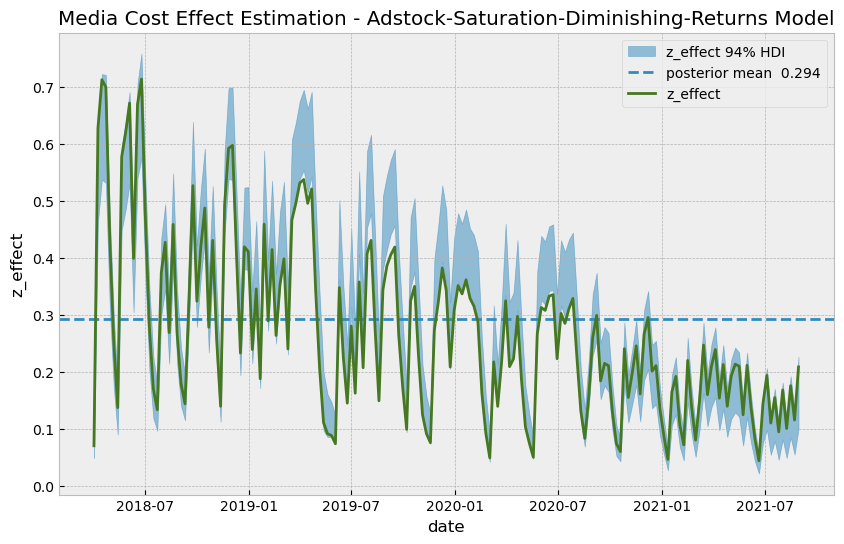

In [100]:
z_effect_posterior_samples = xr.apply_ufunc(
    lambda x: endog_scaler.inverse_transform(X=x.reshape(1, -1)),
    asdr_model_trace.posterior["z_effect"],
    input_core_dims=[["date"]],
    output_core_dims=[["date"]],
    vectorize=True,
)

z_effect_hdi = az.hdi(ary=z_effect_posterior_samples)["z_effect"]

fig, ax = plt.subplots()
ax.fill_between(
    x=date,
    y1=z_effect_hdi[:, 0],
    y2=z_effect_hdi[:, 1],
    color="C0",
    alpha=0.5,
    label="z_effect 94% HDI",
)
ax.axhline(
    y=z_effect_posterior_samples.mean(),
    color="C0",
    linestyle="--",
    label=f"posterior mean {z_effect_posterior_samples.mean().values: 0.3f}",
)
sns.lineplot(x="date", y="z_effect", color="C3", data=data_df, label="z_effect", ax=ax)
ax.legend(loc="upper right")
ax.set(
    title="Media Cost Effect Estimation - Adstock-Saturation-Diminishing-Returns Model"
);

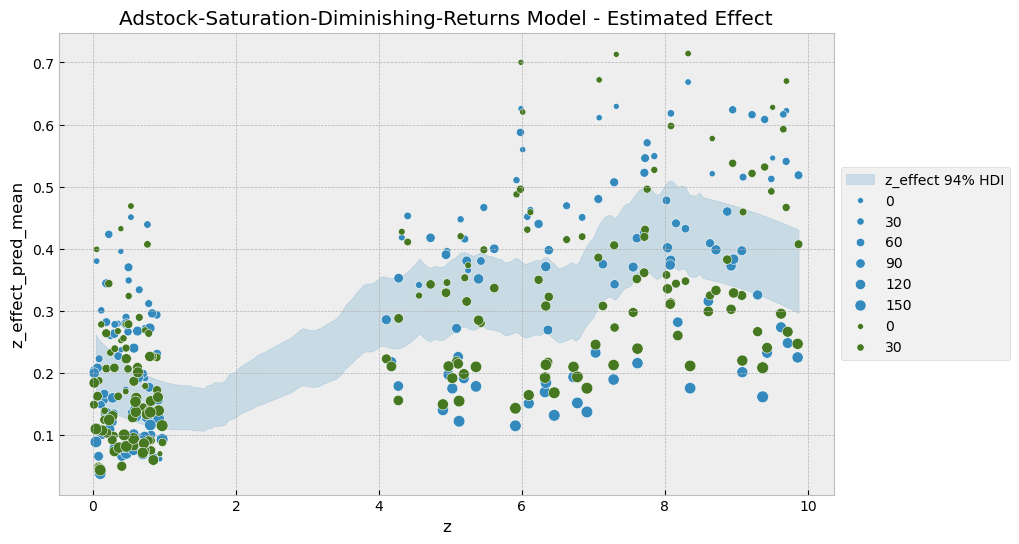

In [103]:
fig, ax = plt.subplots()

az.plot_hdi(
    x=z,
    y=z_effect_posterior_samples,
    color="C0",
    fill_kwargs={"alpha": 0.2, "label": "z_effect 94% HDI"},
    ax=ax,
)
sns.scatterplot(
    x="z",
    y="z_effect_pred_mean",
    color="C0",
    size="index",
    # label="z_effect (pred mean)",
    data=data_df.assign(
        z_effect_pred_mean=z_effect_posterior_samples.mean(dim=("chain", "draw"))
    ),
    ax=ax,
)
sns.scatterplot(
    x="z", y="z_effect", color="C3", size="index", 
    # label="z_effect (true)", 
    data=data_df
)
h, l = ax.get_legend_handles_labels()
ax.legend(handles=h[:9], labels=l[:9], loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Adstock-Saturation-Diminishing-Returns Model - Estimated Effect");

In [104]:
z_effect_hdi = az.hdi(ary=z_effect_posterior_samples)["z_effect"]

data_df = data_df.assign(
    z_effect_pred_mean=z_effect_posterior_samples.mean(dim=("chain", "draw")),
    z_effect_hdi_lower=z_effect_hdi[:, 0],
    z_effect_hdi_upper=z_effect_hdi[:, 1],
)

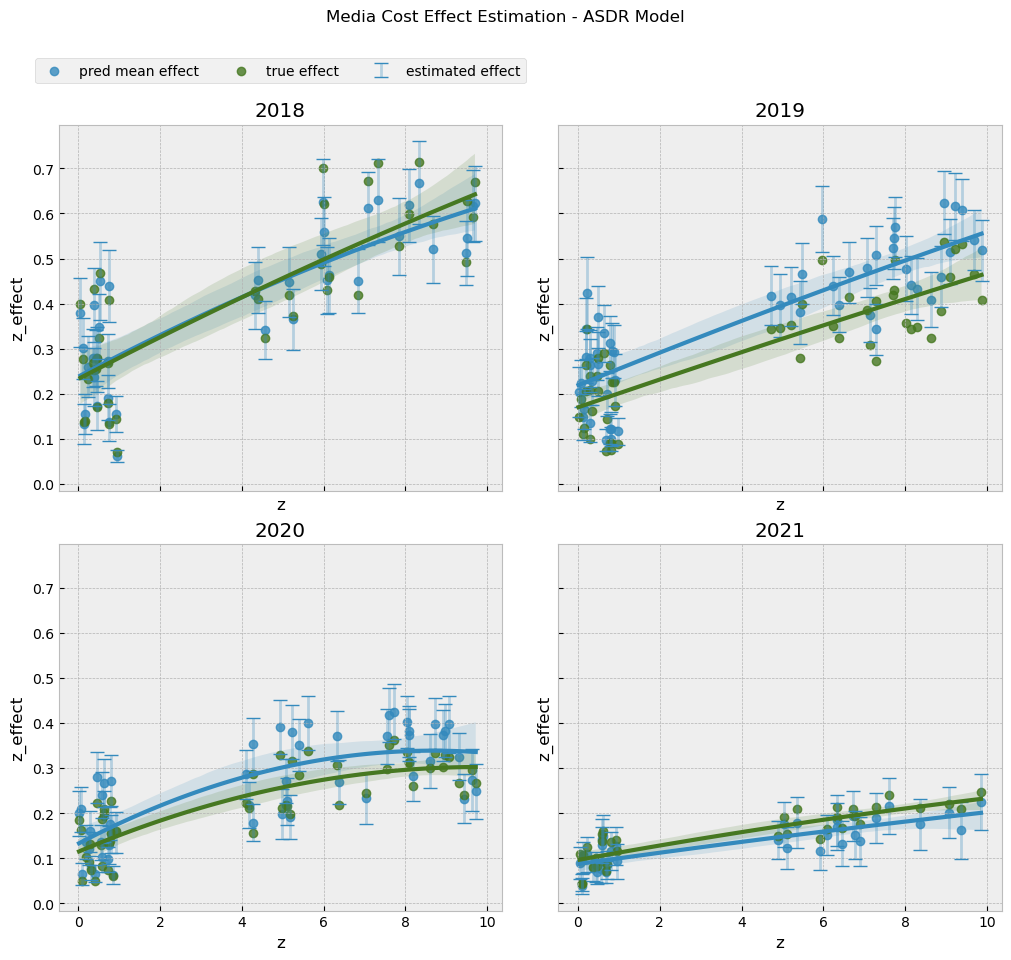

In [105]:
fig, axes = plt.subplots(
    nrows=2, ncols=2, figsize=(10, 9), sharex=True, sharey=True, layout="constrained"
)

axes = axes.flatten()

for i, year in enumerate(data_df["year"].sort_values().unique()):
    ax = axes[i]
    mask = f"year == {year}"

    yerr = (
        data_df.query(mask)["z_effect_hdi_upper"]
        - data_df.query(mask)["z_effect_hdi_lower"]
    )

    markers, caps, bars = ax.errorbar(
        x=data_df.query(mask)["z"],
        y=data_df.query(mask)["z_effect_pred_mean"],
        yerr=yerr / 2,
        color="C0",
        fmt="o",
        ms=0,
        capsize=5,
        label="estimated effect",
    )
    [bar.set_alpha(0.3) for bar in bars]
    sns.regplot(
        x="z",
        y="z_effect_pred_mean",
        order=2,
        color="C0",
        label="pred mean effect",
        data=data_df.query(mask),
        ax=ax,
    )
    sns.regplot(
        x="z",
        y="z_effect",
        order=2,
        color="C3",
        label="true effect",
        data=data_df.query(mask),
        ax=ax,
    )
    if i == 0:
        ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.2), ncol=3)
    else:
        ax.legend().remove()
    ax.set(title=f"{year}")

fig.suptitle("Media Cost Effect Estimation - ASDR Model", y=1.05);

## ROAS and mROAS

### ROAS

In [106]:
asdr_model_trace_roas = asdr_model_trace.copy()

with asdr_model:
    pm.set_data(new_data={"z_scaled": np.zeros_like(a=z_scaled)})
    asdr_model_trace_roas.extend(
        other=pm.sample_posterior_predictive(trace=asdr_model_trace_roas, var_names=["likelihood"])
    )

Sampling: [likelihood]


In [107]:
asdr_roas_numerator = (
    endog_scaler.inverse_transform(
        X=az.extract(
            data=asdr_model_posterior_predictive,
            group="posterior_predictive",
            var_names=["likelihood"],
        )

    )
    - endog_scaler.inverse_transform(
        X=az.extract(
            data=asdr_model_trace_roas,
            group="posterior_predictive",
            var_names=["likelihood"],
        )
    )
).sum(axis=0)

roas_denominator = z.sum()

asdr_roas = asdr_roas_numerator / roas_denominator

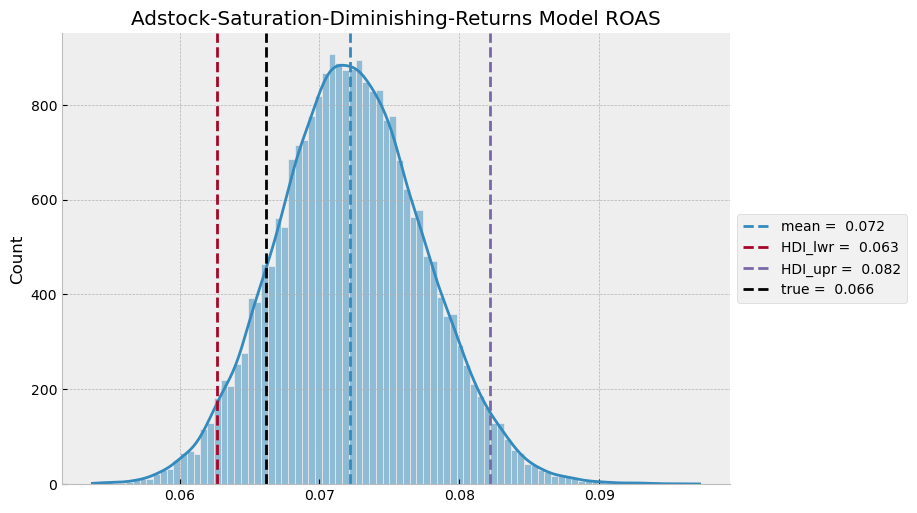

In [108]:
asdr_roas_mean = np.median(asdr_roas)
asdr_roas_hdi = az.hdi(ary=asdr_roas)

g = sns.displot(x=asdr_roas, kde=True, height=5, aspect=1.5)
ax = g.axes.flatten()[0]
ax.axvline(
    x=asdr_roas_mean, color="C0", linestyle="--", label=f"mean = {asdr_roas_mean: 0.3f}"
)
ax.axvline(
    x=asdr_roas_hdi[0],
    color="C1",
    linestyle="--",
    label=f"HDI_lwr = {asdr_roas_hdi[0]: 0.3f}",
)
ax.axvline(
    x=asdr_roas_hdi[1],
    color="C2",
    linestyle="--",
    label=f"HDI_upr = {asdr_roas_hdi[1]: 0.3f}",
)
ax.axvline(x=roas_true, color="black", linestyle="--", label=f"true = {roas_true: 0.3f}")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Adstock-Saturation-Diminishing-Returns Model ROAS");

### mROAS

In [109]:
eta: float = 0.10

asdr_model_trace_mroas = asdr_model_trace.copy()

with asdr_model:
    pm.set_data(new_data={"z_scaled": (1 + eta) * z_scaled})
    asdr_model_trace_mroas.extend(
        other=pm.sample_posterior_predictive(trace=asdr_model_trace_mroas, var_names=["likelihood"])
    )

Sampling: [likelihood]


In [110]:
asdr_mroas_numerator = (
    endog_scaler.inverse_transform(
        X=az.extract(
            data=asdr_model_trace_mroas,
            group="posterior_predictive",
            var_names=["likelihood"],
        )
    )
    - endog_scaler.inverse_transform(
        X=az.extract(
            data=asdr_model_posterior_predictive,
            group="posterior_predictive",
            var_names=["likelihood"],
        )
    )
).sum(axis=0)

mroas_denominator = eta * z.sum()

asdr_mroas = asdr_mroas_numerator / mroas_denominator

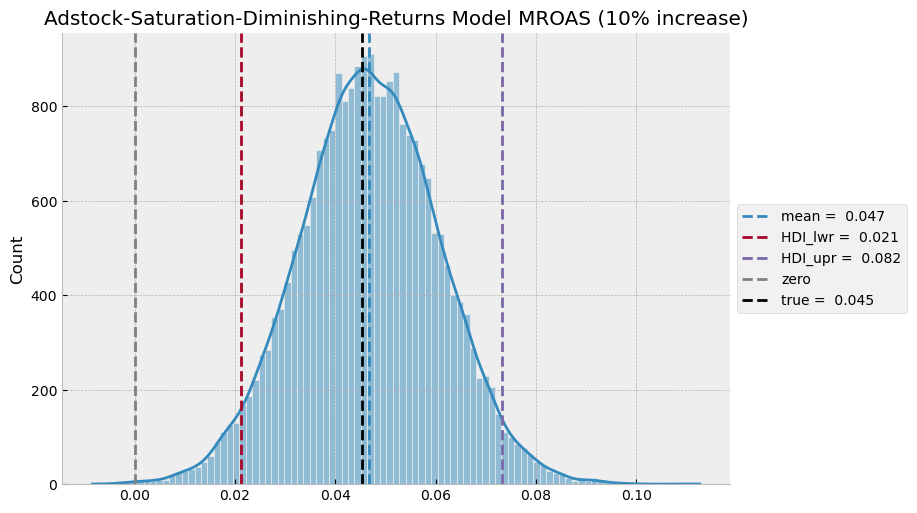

In [111]:
asdr_mroas_mean = asdr_mroas.mean()
asdr_mroas_hdi = az.hdi(ary=asdr_mroas)

g = sns.displot(x=asdr_mroas, kde=True, height=5, aspect=1.5)
ax = g.axes.flatten()[0]
ax.axvline(
    x=asdr_mroas_mean, color="C0", linestyle="--", label=f"mean = {asdr_mroas_mean: 0.3f}"
)
ax.axvline(
    x=asdr_mroas_hdi[0],
    color="C1",
    linestyle="--",
    label=f"HDI_lwr = {asdr_mroas_hdi[0]: 0.3f}",
)
ax.axvline(
    x=asdr_mroas_hdi[1],
    color="C2",
    linestyle="--",
    label=f"HDI_upr = {asdr_roas_hdi[1]: 0.3f}",
)
ax.axvline(x=0.0, color="gray", linestyle="--", label="zero")
ax.axvline(x=mroas_true, color="black", linestyle="--", label=f"true = {mroas_true: 0.3f}")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title=f"Adstock-Saturation-Diminishing-Returns Model MROAS ({eta:.0%} increase)");

# MODEL COMPARISON

In [112]:
dataset_dict = {
    "base_model": base_model_trace,
    "adstock_saturation_model": adstock_saturation_model_trace,
    "asdr_model": asdr_model_trace,
}

az.compare(compare_dict=dataset_dict, ic="loo", method="stacking", scale="log")

c:\Users\migue\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
c:\Users\migue\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'log' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (


rank    elpd_loo      p_loo   elpd_diff    weight  \
asdr_model                   0  564.976094  36.416506    0.000000  0.983093   
adstock_saturation_model     1  518.427182  20.727117   46.548913  0.016907   
base_model                   2  464.312353  18.103020  100.663741  0.000000   

                                 se        dse  warning scale  
asdr_model                 9.043391   0.000000    False   log  
adstock_saturation_model   8.774833   8.854762    False   log  
base_model                10.820994  12.763703    False   log

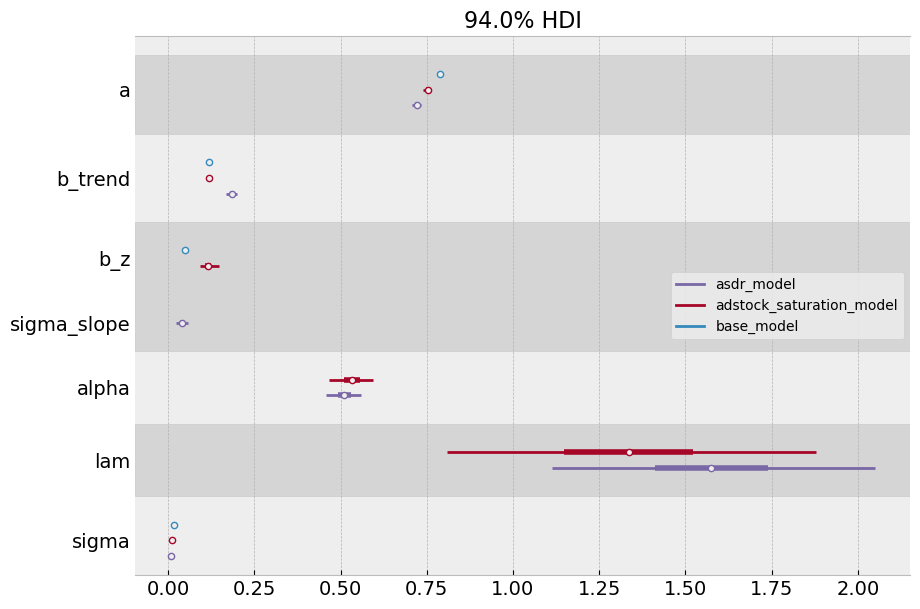

In [113]:
axes = az.plot_forest(
    data=[base_model_trace, adstock_saturation_model_trace, asdr_model_trace],
    model_names=["base_model", "adstock_saturation_model", "asdr_model"],
    var_names=["a", "b_trend", "b_z", "sigma_slope", "alpha", "lam", "sigma"],
    combined=True,
    figsize=(10, 7),
);

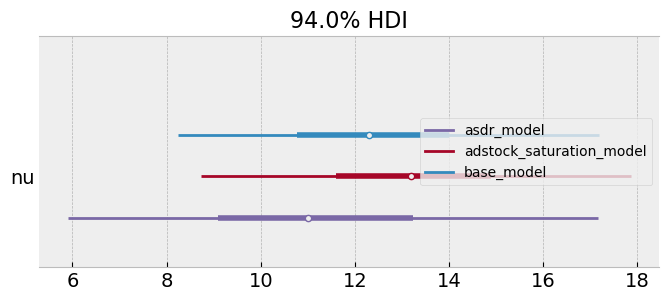

In [114]:
axes = az.plot_forest(
    data=[base_model_trace, adstock_saturation_model_trace, asdr_model_trace],
    model_names=["base_model", "adstock_saturation_model", "asdr_model"],
    var_names=["nu"],
    combined=True,
    figsize=(8, 3),
);

In [115]:
roas_samples_df = (
    pd.DataFrame(
        data={
            "base": base_roas,
            "adstock-saturation": adstock_saturation_roas,
            "asdr": asdr_mroas,
        }
    )
    .melt()
    .assign(metric="ROAS")
)

mroas_samples_df = (
    pd.DataFrame(
        data={
            "base": base_mroas,
            "adstock-saturation": adstock_saturation_mroas,
            "asdr": asdr_mroas,
        }
    )
    .melt()
    .assign(metric="mROAS")
)

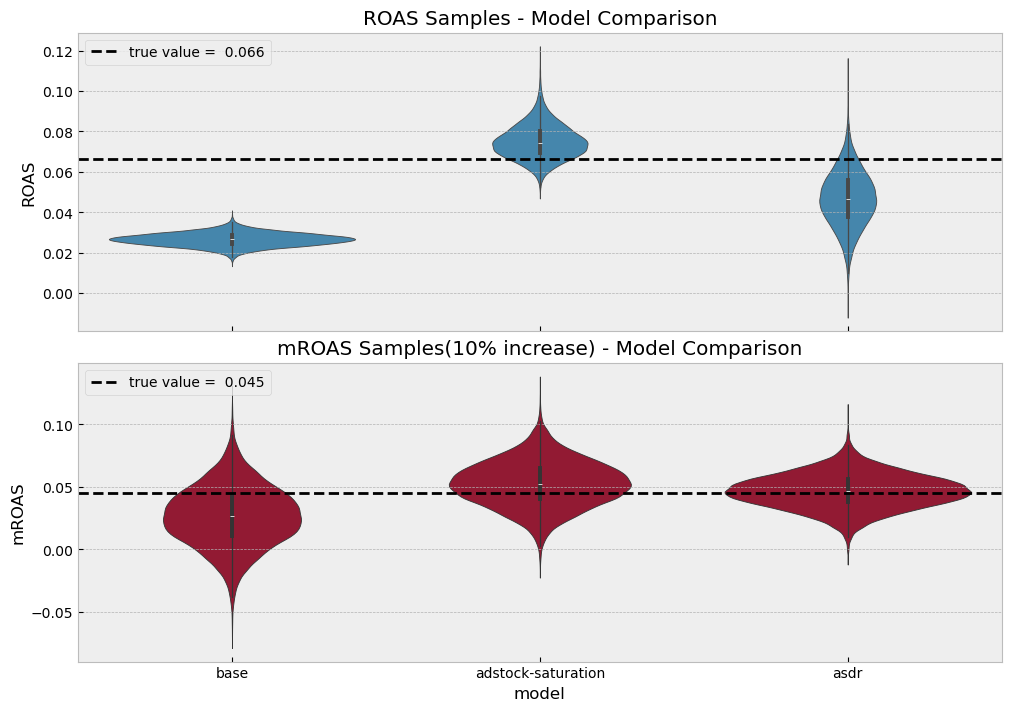

In [116]:
fig, axes = plt.subplots(
    nrows=2, ncols=1, sharex=True, sharey=False, figsize=(10, 7), layout="constrained"
)
sns.violinplot(x="variable", y="value", color="C0", data=roas_samples_df, ax=axes[0])
axes[0].axhline(
    y=roas_true, color="black", linestyle="--", label=f"true value = {roas_true: 0.3f}"
)
axes[0].legend(loc="upper left")
axes[0].set(title="ROAS Samples - Model Comparison", xlabel="model", ylabel="ROAS")
sns.violinplot(x="variable", y="value", color="C1", data=mroas_samples_df, ax=axes[1])
axes[1].axhline(
    y=mroas_true,
    color="black",
    linestyle="--",
    label=f"true value = {mroas_true: 0.3f}",
)
axes[1].legend(loc="upper left")
axes[1].set(
    title=f"mROAS Samples({eta:.0%} increase) - Model Comparison",
    xlabel="model",
    ylabel="mROAS",
);

In [124]:
asdr_model_trace.posterior['z_adstock_saturated'].mean(dim=('chain', 'draw')).max()

<xarray.DataArray 'z_adstock_saturated' ()>
array(0.87478081)